# Run D-SPIN
This notebook contains code for:
- Choosing the number of D-SPIN gene programs
- Generating and interpreting D-SPIN gene programs using oNMF
- Fitting and visualizing the D-SPIN model
- Computational validation of the results

To run all components of this notebook, you will need an OpenAI API key designed in a `.env` file
visible to `dotenv`. This notebook assumes the existence of top-level `data/` and `output` directories. Please see the attached `environment.yml` file in order to reproduce the environment used for this analysis. 

In [1]:
import os
import pickle
import magic
import scprep
import matplotlib
import glob
import copy

import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import matplotlib as mpl
import leidenalg as la
import igraph as ig
import networkx as nx
import seaborn as sns
import matplotlib.patheffects as path_effects

from typing import Optional, Dict, Tuple, Callable
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from sklearn.cluster import KMeans
from dspin.dspin import DSPIN
from scipy.io import mmwrite
from dspin.plot import assign_program_position, gene_program_on_umap, visualize_program_expression
from dspin.annotate import automatic_gpt_annotation
from scipy.sparse import issparse
from scipy.cluster.hierarchy import dendrogram, linkage
from dotenv import load_dotenv
from joblib import Parallel, delayed

BLUE = "#3285CC"
WHITE = "#FFFFFF"
RED = "#E84B23"
PURPLE = "#7b3294"
GREEN = "#008837"

CMAP_HVEC = mpl.colors.LinearSegmentedColormap.from_list("", [BLUE, WHITE, RED])

%matplotlib inline
sc.set_figure_params(
    dpi=300
)
matplotlib.rcParams['pdf.fonttype'] = 42

def set_plotting_mode(mode: str):
    if mode == "inline":
        matplotlib.use("module://matplotlib_inline.backend_inline")
    elif mode == "cairo":
        matplotlib.use('cairo')
    else:
        raise ValueError(f"Invalid plotting mode: {mode}")
set_plotting_mode("cairo")

DATA_DIR = "../data/gbm43_perturb_seq"
OUTPUT_DIR = "../output/gbm43/dspin"
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

## Load data

In [3]:
# Filter for highly variable genes only
gbm43_data = ad.read_h5ad(os.path.join(DATA_DIR, "gbm43_processed.h5ad"))
gbm43_hvg = gbm43_data[:, gbm43_data.var["highly_variable"]].copy()
gbm43_hvg

AnnData object with n_obs × n_vars = 18938 × 3210
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'sorted', 'cond', 'SCT_snn_res.0.4', 'seurat_clusters', 'sgRNA_UMI', 'sgRNA_logUMI', 'sgRNA_binary', 'sgRNA', 'sgRNACond', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_1.0', 'leiden_res_0.02', 'leiden_res_0.50', 'leiden_res_0.70', 'leiden_res_2.00', 'umap_1_group'
    var: 'features', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable'
    uns: 'cond_colors', 'leiden_1.0', 'leiden_1.0_colors', '

## Run D-SPIN

### Compute gene programs

In [6]:
# Since DSPIN modifies the AnnData object in place, make a copy
gbm43_dspin = gbm43_hvg.copy()
model = DSPIN(gbm43_dspin, OUTPUT_DIR)

1812 genes have expression in more than 0.02 of the cells
ProgramDSPIN initialized.


#### Determine number of gene programs (BIC)
We will do this by calculating the Bayesian information criterion and a correlation metric across the gene matrices

In [4]:
# Determine the optimal number of oNMF components. To do this, first generate a
# range of oNMF outputs.
seed = 0
num_gene_programs_list = [5 * i for i in range(1, 21)]
num_repeat = 10
save_path = os.path.join(OUTPUT_DIR, "program_finding_oNMF_outputs")

In [ ]:
def run_model(num):
    model = DSPIN(gbm43_hvg, save_path, num_spin=num)
    model.gene_program_discovery(balance_obs="leiden_1.0", num_repeat=num_repeat, seed=seed)
    return num, model
model_dict = dict(Parallel(n_jobs=8)(delayed(run_model)(num) for num in num_gene_programs_list))

In [7]:
# Next, generate a matrix from the gbm43_dspin object to compare each of the oNMF outputs against.
# Assume the matrix is balanced in terms of samples.
expression_matrix = gbm43_dspin.X
if issparse(expression_matrix):
    gene_matrix_balanced = np.asarray(expression_matrix.toarray())

In [8]:
# Get a matrix that's normalized by standard deviation. This is the same preprocessing
# step done before oNMF.
std = gene_matrix_balanced.std(axis=0)
std_clipped = std.clip(np.percentile(std, 20), np.inf) # Clip to the 20th percentile of std
gene_matrix_balanced_normalized = gene_matrix_balanced / std_clipped

In [49]:
# Load each oNMF model and save its correlation and error against the gene matrix
# Here, error is the reconstruction error between the oNMF estimation and the actual matrix.
# We calculate the Pearson correlation (or cosine similarity of two standardized matrices)
norm_matrix = gene_matrix_balanced_normalized.copy()
norm_matrix -= norm_matrix.mean(axis=0)
norm_matrix /= norm_matrix.std(axis=0)

for idx, num in enumerate(num_gene_programs_list):
    for repeat in range(num_repeat):
        with open(os.path.join(save_path, "onmf", f"onmf_rep_{num}_{repeat}.npy"), "rb") as f:
            nmf_model = np.load(f, allow_pickle=True).item()
        transform = nmf_model.transform(gene_matrix_balanced_normalized)
        reconstruction = transform @ nmf_model.components_
        error = np.linalg.norm(gene_matrix_balanced_normalized - reconstruction)
        reconst_mat = reconstruction.copy()
        reconst_mat -= reconst_mat.mean(axis=0)
        reconst_mat /= reconst_mat.std(axis=0)
        all_corr = (norm_matrix * reconst_mat).sum(axis=0) / norm_matrix.shape[0] # Cosine similarity/correlation
        np.save(os.path.join(OUTPUT_DIR, "regular_corr_outputs", f"error_corr_{num}_{repeat}"), {"corr": all_corr, "error": error})

In [9]:
# Load the errors into a matrix for examining the Bayesian information criterion
errors = np.zeros((len(num_gene_programs_list), num_repeat))
for idx, num in enumerate(num_gene_programs_list):
    for repeat in range(num_repeat):
        corr_error_file = os.path.join(OUTPUT_DIR, "regular_corr_outputs", f"error_corr_{num}_{repeat}.npy")
        corr_error_data = np.load(corr_error_file, allow_pickle=True).item()
        errors[idx, repeat] = corr_error_data["error"]

In [110]:
# What proportion of the matrix norm is represented by the errors?
sc.set_figure_params(figsize=[5, 3])
plt.plot(num_gene_programs_list, errors / np.linalg.norm(gene_matrix_balanced_normalized))
plt.title('Matrix error norm over oNMF repeats')
plt.xlabel('Number of programs', fontsize=12)
plt.ylabel('Error matrix norm', fontsize=12)
plt.savefig(os.path.join(save_path, 'matrix_error_norm_over_repeats.pdf'), bbox_inches='tight', format='pdf')
plt.show()
plt.clf()

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_18527/1991152235.py:8: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [10]:
# Calculate and plot the Bayesian information criterion. Be explicit about the effective sample size
# The Bayesian information criterion includes two terms:
# klog(n) - 2 * log(L), where L is the maximized likelihood of the current model parameter settings
# If we assume that the likelihood of errors is normal, then the likelihood becomes:
# klog(n) + nlog(RSS/n) + C, where RSS is the residual sum of squares

# Recall that here errors is a matrix whose rows are a number of gene programs, and whose columns are repeats
def calculate_bic(rss, n):
    return np.log(rss / n) + np.log(n) / n * np.array(num_gene_programs_list).reshape(-1, 1) * np.ones([1, num_repeat])

In [106]:
sc.set_figure_params(figsize=[2.1, 2])

num_samples = gene_matrix_balanced_normalized.shape[0]
rss = errors ** 2
for effective_sample_size in [num_samples, num_samples / 2, num_samples / 3, num_samples / 5, num_samples / 10]:
    bic = calculate_bic(rss, effective_sample_size)
    plt.plot(np.array(num_gene_programs_list), bic.mean(axis=1), '--', linewidth=1, color='C0')
    plt.scatter(np.repeat(num_gene_programs_list, num_repeat).reshape(-1, num_repeat), bic, 1, color='C0')
    plt.grid()
    plt.xlabel('Number of programs', fontsize=10)
    plt.ylabel('BIC', fontsize=10)
    plt.xticks([15, 25, 35, 45, 60, 75, 90], fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.title('BIC against number of gene programs')
    plt.savefig(os.path.join(save_path, f'onmf_bic_{np.round(effective_sample_size, 0)}.pdf'), bbox_inches='tight')
    plt.show()
    plt.clf()

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_18527/3023786637.py:28: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [32]:
# Export the comparison with the Bayesian information criterion for plotting purposes
effective_sample_size = gene_matrix_balanced_normalized.shape[0] / 2
rss = errors ** 2

# Recall that what's being plotted here is essentially two variables: BIC readout and the number of
# programs. So we'll just create a dataframe with all of the values matched up against each other
dataframe_dict = {
    'Number of gene programs': np.repeat(num_gene_programs_list, num_repeat),
    'BIC': calculate_bic(rss, effective_sample_size).flatten()
}
bic_df = pd.DataFrame(dataframe_dict)
bic_df.to_csv(os.path.join(save_path, f'onmf_bic_{np.round(effective_sample_size, 0)}_table.csv'), index=False, sep='\t')

#### Determine number of gene programs (MAGIC)

In [117]:
# Next, compare the correlation from the regular expression matrix to a magic matrix.
expression_matrix = gbm43_dspin.X
if issparse(expression_matrix):
    gene_matrix_balanced = np.asarray(expression_matrix.toarray())

In [118]:
# Normalize the matrix by standard deviation for each gene. Again, we do this to match
# the preprocessing done on the expression matrix by D-SPIN
std = gene_matrix_balanced.std(axis=0)
std_clipped = std.clip(np.percentile(std, 20), np.inf)
gene_matrix_balanced_normalized = gene_matrix_balanced / std_clipped

In [119]:
# Load each oNMF model and save its correlation and error against the gene matrix
norm_matrix = gene_matrix_balanced_normalized.copy()
norm_matrix -= norm_matrix.mean(axis=0)
norm_matrix /= norm_matrix.std(axis=0)
norm_regular_matrix = norm_matrix.copy()

In [131]:
# Calculate auto-correlation in the normalized regular matrix
corr_all_genes = norm_matrix.T.dot(norm_matrix) / norm_matrix.shape[0]
np.fill_diagonal(corr_all_genes, 0)
plt.hist(corr_all_genes.flatten(), bins=50)
plt.yscale("log")
plt.ylabel("Correlation")
plt.title("Correlation over all genes")
plt.savefig(os.path.join(save_path, "auto_correlation_normalized_expr_matrix.pdf"), format="pdf", bbox_inches='tight')
plt.clf()

In [116]:
# What is the correlation that will place us 3 standard deviations (99.7th percentile) above the mean?
print(f"Standard deviation: {corr_all_genes.std()}")
print(f"3 sigma percentile: {np.percentile(corr_all_genes.flatten(), 99.7)}")

Standard deviation: 0.02625561389611669
3 sigma percentile: 0.1478063288388874


In [124]:
# Let's take a small example and take a look at the correlation
num_programs = 5
rep = 0
corr_file = os.path.join(OUTPUT_DIR, "regular_corr_outputs", f"error_corr_{num_programs}_{rep}.npy")
corr_data = np.load(corr_file, allow_pickle=True).item()
corr = corr_data["corr"]
plt.hist(corr, bins=100)
plt.yscale("log")
plt.ylabel("Correlation")
plt.title("Correlation against 5 program reconstruction")
plt.savefig(os.path.join(save_path, "5_programs_normalized_expr_matrix_.pdf"), format="pdf", bbox_inches='tight')
plt.clf()

In [28]:
# Examine correlation over the number of gene programs
corrs_regular = np.zeros((len(num_gene_programs_list), num_repeat))
for idx, num in enumerate(num_gene_programs_list):
    for repeat in range(num_repeat):
        corr_file = os.path.join(OUTPUT_DIR, "regular_corr_outputs", f"error_corr_{num}_{repeat}.npy")
        corr_data = np.load(corr_file, allow_pickle=True).item()
        corr = corr_data["corr"]
        corrs_regular[idx, repeat] = np.sum(corr > 0.148) / corr.size

In [136]:
plt.plot(num_gene_programs_list, corrs_regular)
plt.savefig(os.path.join(save_path, "corrs_against_gene_programs.pdf"), format="pdf", bbox_inches='tight')
plt.clf() # As expected, with increasing gene programs, we get increasing correlation between reconstruction and actual

In [137]:
# Instead of using the expression matrix, try denoising using MAGIC
# Read in the raw data matrix for use with MAGIC
gbm43_data = ad.read_h5ad(os.path.join(DATA_DIR, "gbm43.h5ad"))

# Run the same preprocessing steps we'd usually run
gbm43_data.var_names = gbm43_data.var_names.str.replace("^GRCh38-", "", regex=True)
sc.pp.filter_cells(gbm43_data, min_genes=100)
sc.pp.filter_genes(gbm43_data, min_cells=3)
sc.pp.normalize_total(gbm43_data) # Note that we will use the square root transform to preserve 0s

In [72]:
# Write the matrix to an .mtx file so we can use it in MAGIC
mmwrite(os.path.join(DATA_DIR, "gbm43_magic_raw_matrix.mtx"), gbm43_data.X)

# Save the cell (obs) and gene (var) names to text files
gbm43_data.obs_names.to_series().to_csv(os.path.join(DATA_DIR, "gbm43_magic_raw_barcodes.tsv"), index=False, header=False)  # Cell names
gbm43_data.var_names.to_series().to_csv(os.path.join(DATA_DIR, "gbm43_magic_raw_genes.tsv"), index=False, header=False)  # Gene names

In [ ]:
# Load in the matrix to scprep
gbm43_scprep = scprep.io.load_mtx(
    os.path.join(DATA_DIR, "gbm43_magic_raw_matrix.mtx"),
    gene_names=os.path.join(DATA_DIR, "gbm43_magic_raw_genes.tsv"),
    cell_names=os.path.join(DATA_DIR, "gbm43_magic_raw_barcodes.tsv")
)
gbm43_scprep

/opt/miniconda3/envs/human_gbm_dnapk/lib/python3.11/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<AxesSubplot: xlabel='Library size', ylabel='Number of cells'>

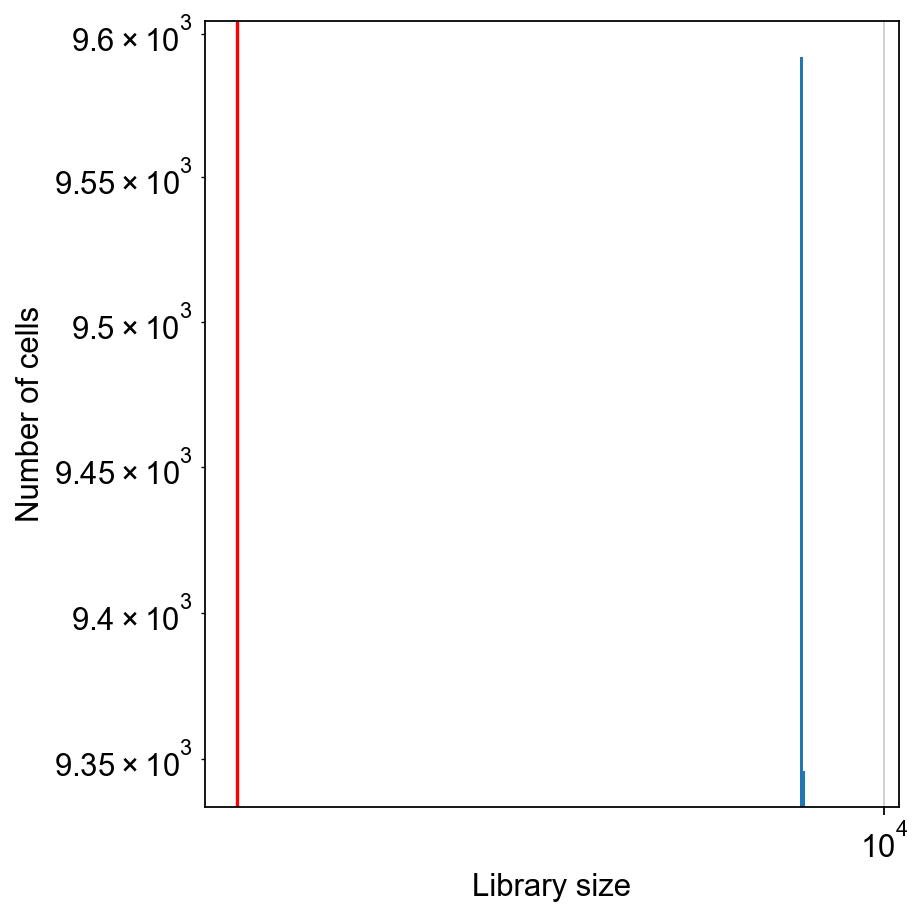

In [74]:
# Check out the library sizes
scprep.plot.plot_library_size(gbm43_scprep, cutoff=1500, figsize=(6, 6))

# Note that this is library-normalized, as we expect

In [75]:
# Do a square root transform so that we have n oissue with zeroes.
gbm43_scprep = scprep.transform.sqrt(gbm43_scprep)
gbm43_scprep

,AL627309.1,AL627309.3,AL627309.5,AL669831.2,LINC01409,FAM87B,LINC01128,LINC00115,FAM41C,AL645608.2,...,BX004987.1,AC145212.1,MAFIP,AC011043.1,AL354822.1,AL592183.1,AC240274.1,AC004556.3,AC007325.1,AC007325.4
AGAGCCCGTTTGCCGG-1_1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.520293,0.0,0.000000,0.0,0.0,0.0
AGGTTACGTCTACATG-1_1,0.0,0.0,0.405694,0.0,0.000000,0.0,0.405694,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.405694,0.0,0.405694,0.0,0.0,0.0
ATTATCCAGGTACATA-1_1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.592678,0.0,0.000000,0.0,0.0,0.0
CATTCCGTCACTTTGT-1_1,0.0,0.0,0.000000,0.0,0.532796,0.0,0.532796,0.000000,0.0,0.532796,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.532796,0.0,0.0,0.0
CATTTCAAGAAGTCAT-1_1,0.0,0.0,0.000000,0.0,0.404752,0.0,0.000000,0.404752,0.0,0.000000,...,0.0,0.0,0.0,0.572405,0.404752,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGGTAGTCG-1_14,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.834693,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
AGATAGATCGAGTTGT-1_14,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
CTAACCCGTAGAGCTG-1_14,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
GATGACTGTGGAAATT-1_14,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [76]:
# Since we'll only run MAGIC on the genes we model in DSPIN, find those genes here
dspin_genes = gbm43_dspin.var_names.to_list()

In [77]:
# Run MAGIÇ, but only on genes we'll be using for DSPIN
magic_op = magic.MAGIC()
gbm43_magic = magic_op.fit_transform(gbm43_scprep, genes=dspin_genes)

Calculating MAGIC...
  Running MAGIC on 18938 cells and 23511 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 60.73 seconds.
    Calculating KNN search...
    Calculated KNN search in 57.81 seconds.
    Calculating affinities...
    Calculated affinities in 57.74 seconds.
  Calculated graph and diffusion operator in 178.45 seconds.
  Calculating imputation...
  Calculated imputation in 2.34 seconds.
Calculated MAGIC in 188.26 seconds.


In [23]:
# Export this matrix for future purposes
scprep.io.save_mtx(gbm43_magic,
                   os.path.join(data_dir, "gbm43_magic_processed_matrix")
)
gbm43_magic = scprep.io.load_mtx(
                   os.path.join(DATA_DIR, "gbm43_magic_processed_matrix", "matrix.mtx"),
                   cell_names=os.path.join(DATA_DIR, "gbm43_magic_processed_matrix", "cell_names.tsv"),
                   gene_names=os.path.join(DATA_DIR, "gbm43_magic_processed_matrix", "gene_names.tsv")
)

In [24]:
# But for now, keep it as a numpy matrix so we can calculate correlation and reconstruction error 
gbm43_magic_np = gbm43_magic.to_numpy()

In [25]:
# Standardize the matrix as before
std = gbm43_magic_np.std(axis=0)
std_clipped = std.clip(np.percentile(std, 20), np.inf)
gene_matrix_balanced_normalized = gbm43_magic_np / std_clipped

In [142]:
# Load each oNMF model and save its correlation and error against the gene matrix
# Here, error is the reconstruction error between the oNMF estimation and the actual matrix.
# We calculate the Pearson correlation (or cosine similarity of two standardized matrices)
norm_matrix = gene_matrix_balanced_normalized.copy()
norm_matrix -= norm_matrix.mean(axis=0)
norm_matrix /= norm_matrix.std(axis=0)
norm_matrix_magic = norm_matrix.copy()

for idx, num in enumerate(num_gene_programs_list):
    for repeat in range(num_repeat):
        with open(os.path.join(save_path, "onmf", f"onmf_rep_{num}_{repeat}.npy"), "rb") as f:
            nmf_model = np.load(f, allow_pickle=True).item()
        transform = nmf_model.transform(gene_matrix_balanced_normalized)
        reconstruction = transform @ nmf_model.components_
        error = np.linalg.norm(gene_matrix_balanced_normalized - reconstruction)
        reconst_mat = reconstruction.copy()
        reconst_mat -= reconst_mat.mean(axis=0)
        reconst_mat /= reconst_mat.std(axis=0)
        all_corr = (norm_matrix * reconst_mat).sum(axis=0) / norm_matrix.shape[0]
        np.save(os.path.join(OUTPUT_DIR, "magic_corr_outputs", f"error_corr_{num}_{repeat}"), {"corr": all_corr, "error": error})

In [26]:
# Load the errors into a matrix for examining the Bayesian information criterion
errors = np.zeros((len(num_gene_programs_list), num_repeat))
for idx, num in enumerate(num_gene_programs_list):
    for repeat in range(num_repeat):
        corr_file = os.path.join(OUTPUT_DIR, "magic_corr_outputs", f"error_corr_{num}_{repeat}.npy")
        corr_data = np.load(corr_file, allow_pickle=True).item()
        errors[idx, repeat] = corr_data["error"]

In [151]:
# Plot what proportion of the norm is represented by the size of the error:
plt.figure(figsize=[5, 3])
plt.plot(num_gene_programs_list, errors / np.linalg.norm(gene_matrix_balanced_normalized))
plt.title('Error against number of gene programs (MAGIC)')
plt.ylabel('Reconstruction error')
plt.xlabel('Number of gene programs')
plt.savefig(os.path.join(save_path, 'magic_error_over_number_gene_programs.pdf'), format='pdf', bbox_inches='tight')
plt.clf()

In [152]:
# Now calculate the auto-correlation in the matrix
corr_all_genes = norm_matrix_magic.T.dot(norm_matrix_magic) / norm_matrix_magic.shape[0]
np.fill_diagonal(corr_all_genes, 0)
plt.figure(figsize=[5, 3])
plt.hist(corr_all_genes.flatten(), bins=100)
plt.title('Histogram of autocorrelation in MAGIC corrected matrix')
plt.ylabel('Frequency')
plt.xlabel('Auto-correlation'),
plt.yscale("log")
plt.savefig(os.path.join(save_path, 'magic_autocorrelation.pdf'), format='pdf', bbox_inches='tight')
plt.clf()

In [153]:
# What is the correlation that will place us 3 standard deviations (99.7th percentile) above the mean?
print(f"Standard deviation: {corr_all_genes.std()}")
print(f"3 sigma percentile: {np.percentile(corr_all_genes.flatten(), 99.7)}")

Standard deviation: 0.24712619247477452
3 sigma percentile: 0.8054491845745501


In [154]:
# Let's take a small example and take a look at the correlation
num_programs = 5
rep = 0
corr_file = os.path.join(OUTPUT_DIR, "magic_corr_outputs", f"corr_{num_programs}_{rep}.npy")
corr_data = np.load(corr_file, allow_pickle=True).item()
corr = corr_data["corr"]
plt.figure(figsize=[5, 3])
plt.hist(corr, bins=100)
plt.title('Correlation between 5 program reconstruction and original')
plt.ylabel('Frequency')
plt.xlabel('Correlation'),
plt.savefig(os.path.join(save_path, '5_program_correlation_magic.pdf'), format='pdf', bbox_inches='tight')
plt.clf()

In [27]:
# Examine correlation over the number of gene programs
corrs_magic = np.zeros((len(num_gene_programs_list), num_repeat))
for idx, num in enumerate(num_gene_programs_list):
    for repeat in range(num_repeat):
        corr_file = os.path.join(OUTPUT_DIR, "magic_corr_outputs", f"corr_{num}_{repeat}.npy")
        corr_data = np.load(corr_file, allow_pickle=True).item()
        corr = corr_data["corr"]
        corrs_magic[idx, repeat] = np.sum(corr > 0.5) / corr.size

In [156]:
plt.figure(figsize=[5, 3])
plt.plot(num_gene_programs_list, corrs_magic)
plt.ylabel('Correlation')
plt.xlabel('Number of gene programs')
plt.title('Correlation against number of gene programs, MAGIC corrected')
plt.savefig(os.path.join(save_path, 'correlation_against_gene_programs_magic.pdf'), format='pdf', bbox_inches='tight')
plt.show() # As expected, with increasing gene programs, we get increasing correlation between reconstruction and actual
plt.clf()

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_18527/536399876.py:7: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show() # As expected, with increasing gene programs, we get increasing correlation between reconstruction and actual


In [179]:
ydata = corrs_magic
ydata2 = corrs_regular
plt.figure(figsize=[2.1, 2])
plt.plot(num_gene_programs_list, ydata.mean(axis=1), '--', linewidth=1, color='C1', label='MAGIC')
plt.plot(num_gene_programs_list, ydata2.mean(axis=1), '--', linewidth=1, color='C0', label='Regular')
plt.scatter(np.repeat(num_gene_programs_list, num_repeat).reshape(- 1, num_repeat), ydata, 1, color='C1')
plt.scatter(np.repeat(num_gene_programs_list, num_repeat).reshape(- 1, num_repeat), ydata2, 1, color='C0')
plt.grid()
plt.xlabel('Number of programs', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.xticks([15, 25, 35, 45, 60, 75, 90], fontsize=8, rotation=90)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9], fontsize=8)
plt.title('Proportion against number of gene programs, either 3-sigma (regular) or 0.5 (MAGIC)')
plt.legend()
plt.savefig(os.path.join(save_path, "magic_corrected_correlation_by_programs.pdf"), bbox_inches='tight', format='pdf')
plt.clf()

num_samples = gene_matrix_balanced_normalized.shape[0]
rss = errors ** 2
for effective_sample_size in [num_samples, num_samples / 2, num_samples / 3, num_samples / 5, num_samples / 10]:
    bic = calculate_bic(rss, effective_sample_size)
    plt.plot(np.array(num_gene_programs_list), bic.mean(axis=1), '--', linewidth=1, color='C0')
    plt.scatter(np.repeat(num_gene_programs_list, num_repeat).reshape(-1, num_repeat), bic, 1, color='C0')
    plt.grid()
    plt.xlabel('Number of programs', fontsize=10)
    plt.ylabel('BIC', fontsize=10)
    plt.xticks([15, 25, 35, 45, 60, 75, 90], fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.title('BIC against number of gene programs')
    plt.savefig(os.path.join(save_path, f'onmf_bic_{np.round(effective_sample_size, 0)}.pdf'), bbox_inches='tight')
    plt.show()
    plt.clf()

In [31]:
# Extract this data for plotting purposes
df_dict = {
    'corr_regular': corrs_regular.flatten(),
    'corr_magic': corrs_magic.flatten(),
    'num_gene_programs': np.repeat(num_gene_programs_list, num_repeat)
}
magic_corr_df = pd.DataFrame(df_dict)
magic_corr_df.to_csv(os.path.join(save_path, 'magic_corrected_correlation_by_programs.csv'), index=False, sep='\t')

#### Calculate shared gene programs

In [33]:
# Function to hierarchically cluster each of the models as they are produced.

def visualize_program_expression_with_hierarchical_clustering(onmf_summary, spin_name, gene_matrix, onmf_rep_tri, num_gene_programs, fig_folder=None, 
                                 num_gene_select=10, n_clusters=10, subsample=10000):
    """ 
    Heatmap comparisons between gene expression matrix and gene program representation,
    with hierarchical clustering of gene programs.
    
    Args:
    onmf_summary (sklearn.decomposition.NMF): The ONMF summary object.
    spin_name (List[str]): The names of gene programs.
    gene_matrix (numpy.ndarray): The gene expression matrix.
    onmf_rep_tri (numpy.ndarray): The gene program representation.
    fig_folder (str): The folder where the output figure is saved.
    num_gene_select (int): The number of genes to be selected for each gene program. Default is 10.
    n_clusters (int): The number of clusters for KMeans clustering. Default is 5.
    subsample (int): The number cell subsampling for visualization. Default is 10000.
    
    Returns:
    str: Path of the created figure.
    """
    feature_matrix = onmf_summary.components_
    num_programs, _ = feature_matrix.shape

    # Identify the gene program each gene belongs to
    gene_module_index = np.argmax(feature_matrix, axis=0)

    # For each gene program, identify the top selected genes
    gene_module_top_genes = []
    for program_index in range(num_programs):
        genes_in_module = np.where(gene_module_index == program_index)[0]
        matrix_for_genes_in_module = feature_matrix[program_index, genes_in_module]
        top_genes = genes_in_module[np.argsort(-matrix_for_genes_in_module)[:num_gene_select]]
        gene_module_top_genes += list(top_genes)
    gene_module_top_genes = np.array(gene_module_top_genes)
    
    # Create subset of cells and reorder based on KMeans
    np.random.seed(0)
    onmf_rep_subset = onmf_rep_tri
    subset_ind = range(gene_matrix.shape[0])
    if subsample:
        if gene_matrix.shape[0] > subsample:
            subset_ind = np.random.choice(range(gene_matrix.shape[0]), size=subsample, replace=False)
            onmf_rep_subset = onmf_rep_tri[subset_ind, :]
    cell_order = np.argsort(KMeans(n_clusters=n_clusters).fit_predict(onmf_rep_subset))
    
    # Prepare gene matrix subset
    gene_matrix_subset = gene_matrix[subset_ind, :][:, gene_module_top_genes].copy()
    gene_matrix_subset /= np.max(gene_matrix, axis=0)[gene_module_top_genes].clip(0.2, np.inf)
    
    # Compute hierarchical clustering of gene programs
    # Using correlation distance between program activities
    program_linkage = linkage(onmf_rep_subset.T, method='average', metric='correlation', optimal_ordering=True)

    # Create figure with hierarchical clustering dendrogram
    fig = plt.figure(figsize=(15, 8))
    
    # Define grid for subplots
    gs = plt.GridSpec(1, 2, width_ratios=[1, 4], height_ratios=[1])
    
    # Plot dendrogram
    ax_dendr = fig.add_subplot(gs[0, 0])
    dendrogram(program_linkage, leaf_rotation=90, orientation="left", no_labels=False)
    ax_dendr.set_xticklabels([])
    plt.title('Gene Program Clustering')
    
    # Get the order of programs from dendrogram
    program_order = dendrogram(program_linkage, no_plot=True)['leaves'][::-1]
    
    # Plot Gene Program Expression with reordered programs
    ax_prog = fig.add_subplot(gs[0, 1])
    plt.imshow(onmf_rep_subset.T[program_order, :][:, cell_order],
               aspect='auto', cmap='Blues', interpolation='none')
    plt.yticks(range(num_gene_programs), [spin_name[i] for i in program_order], fontsize=12)
    plt.gca().yaxis.set_ticks_position('right')
    plt.xlabel('Cell')
    plt.title('Gene program expression')
    plt.grid()
    
    # Adjust layout
    plt.tight_layout()
    
    if fig_folder is not None:
        plt.savefig(fig_folder + 'gene_program_decomposition_hierarchical.png', bbox_inches='tight')
        return fig_folder + 'gene_program_decomposition_hierarchical.png'

In [32]:
# Calculate the shared gene programs across RT and noRT.
seed = 0
num_gene_programs = 25 # Based on MAGIC and BIC
num_repeat = 20
save_path = os.path.join(OUTPUT_DIR, "combined_oNMF_outputs")
model = DSPIN(gbm43_hvg, save_path, num_spin=num_gene_programs)
model.gene_program_discovery(balance_obs="leiden_1.0", num_repeat=num_repeat, seed=seed)

1812 genes have expression in more than 0.02 of the cells
ProgramDSPIN initialized.


#### Identify the gene programs

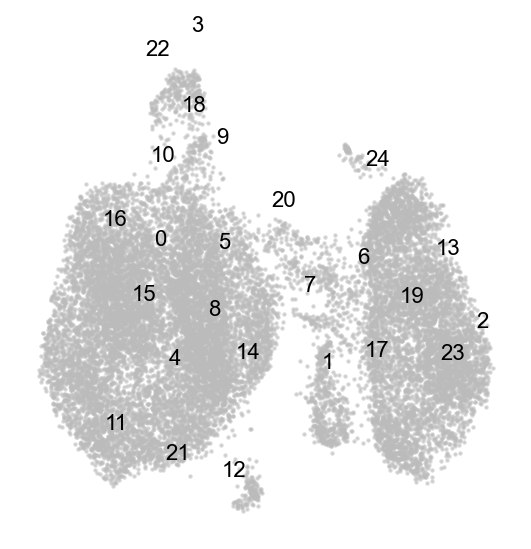

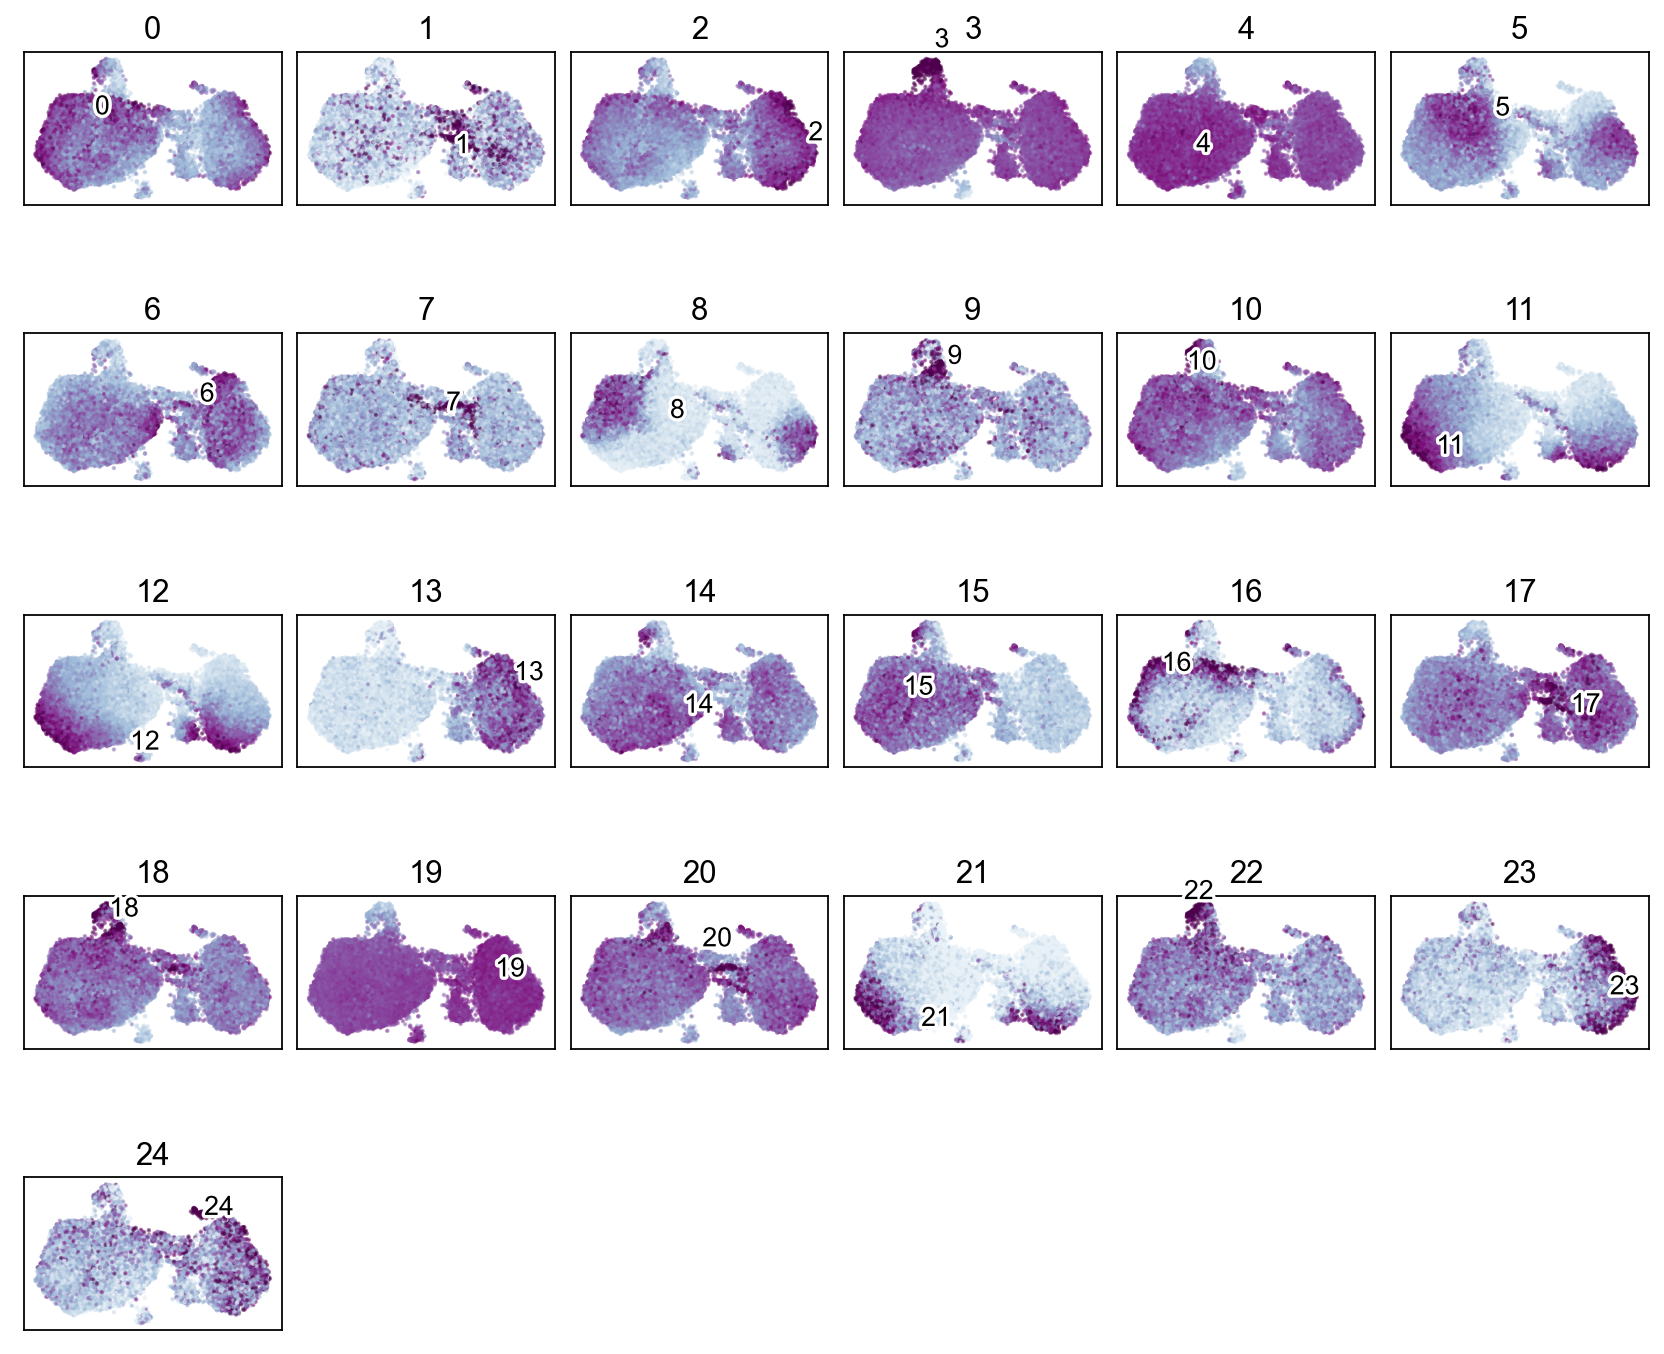

In [276]:
# View the programs on UMAP space
program_umap_pos = assign_program_position(model.program_representation, gbm43_hvg.obsm["X_umap"], repulsion=4)
np.save(os.path.join(save_path,'program_umap_pos_0_30_30.npy'), program_umap_pos)
gene_program_on_umap(model.program_representation, gbm43_hvg.obsm['X_umap'], program_umap_pos, subsample=False)
plt.show()

In [240]:
# Visualize the programs in UMAP space
gene_program_indices = [i for i in range(num_gene_programs)]
visualize_program_expression(model.onmf_decomposition, gene_program_indices, gbm43_hvg.X.toarray(), model.program_discretized, fig_folder=save_path + "/")

'../output/gbm43/dspin/combined_oNMF_outputs/gene_program_decomposition.png'

In [278]:
# Generate automatic annotations using GPT-4o
file_name = "gene_programs_0_25_25.csv"
automatic_gpt_annotation(
    save_path + "/",
    file_name,
    "gpt-4o",
    max_gene=100
)

In [287]:
# Label the annotations
gene_program_output_dir = os.path.join(save_path, file_name.replace(".csv", "_gpt"))
program_dict = {}
for file_path in glob.glob(os.path.join(gene_program_output_dir, "*.txt")):
    with open(file_path, 'r') as file:
        first_line = file.readline().strip()
        program_number = os.path.basename(file_path).split('_')[1].replace('.txt', '')
        program_dict[program_number] = first_line.replace("Process: ", "")
program_dict

{'0': 'Extracellular matrix organization and cell signaling (0.78)',
 '1': 'Cellular stress response and extracellular matrix remodeling (0.78)',
 '3': 'Mitochondrial electron transport and oxidative phosphorylation (0.85)',
 '2': 'Extracellular matrix organization and cell signaling (0.78)',
 '6': 'System of unrelated proteins (0.00)',
 '7': 'Amino acid metabolism and stress response regulation (0.85)',
 '5': 'DNA Replication and Repair (0.95)',
 '4': 'Cytoskeletal Dynamics and Signal Transduction (0.72)',
 '16': 'Extracellular matrix organization and cell adhesion (0.78)',
 '17': 'Cellular stress response and cytoskeletal dynamics (0.72)',
 '15': 'System of unrelated proteins (0.00)',
 '14': 'Cholesterol biosynthesis and protein folding (0.85)',
 '10': 'Extracellular matrix organization and cellular architecture (0.85)',
 '11': 'Mitotic Spindle Assembly and Chromosome Segregation (0.98)',
 '13': 'System of unrelated proteins (0.00)',
 '12': 'Mitotic Cell Cycle Regulation (0.98)',
 '2

In [257]:
# Use the enrichr API to additionally query these gene sets against known gene ontologies
from dspin.annotate import read_data

file_name = "gene_programs_0_25_25.csv"
gene_programs, _ = read_data(save_path, file_name)
gene_program_dict = {}
for i in range(gene_programs.shape[1]):
    gene_list = gene_programs[str(i)]
    gene_list = gene_list[~gene_list.isna()]
    gene_program_dict[i] = gene_list.tolist()

In [274]:
# Write all of the existing Enrichr outputs to files for better saving
import requests
import json

ADD_LIST_ENDPOINT = "https://maayanlab.cloud/Enrichr/addList"
QUERY_ENDPOINT = "https://maayanlab.cloud/Enrichr/enrich"
gene_set_libraries = [
    "GO_Biological_Process_2023",
    "GO_Cellular_Component_2023",
    "GO_Molecular_Function_2023",
    "KEGG_2021_Human",
    "MSigDB_Hallmark_2020",
    "Reactome_Pathways_2024",
    "WikiPathways_2024_Human"
]
ENRICHR_DIR = os.path.join(save_path, "gene_programs_0_25_25_enrichr")

for gene_set_key in gene_program_dict.keys():
    gene_list = gene_program_dict[gene_set_key]
    genes_str = "\n".join(gene_list)
    description = f"Gene set {gene_set_key}"
    payload = {
        "list": (None, genes_str),
        "description": (None, description)
    }
    response = requests.post(ADD_LIST_ENDPOINT, files=payload)
    if not response.ok:
        raise Exception("Error analyzing gene list")
    data = json.loads(response.text)

    # Analyze each gene set
    user_list_id = data["userListId"]
    gene_set_terms = {}
    for gene_set_library in gene_set_libraries:
        request_body = f"{QUERY_ENDPOINT}?userListId={user_list_id}&backgroundType={gene_set_library}"
        response = requests.get(request_body)
        if not response.ok:
            raise Exception("Error fetching enrichment results")
        data = json.loads(response.text)[gene_set_library]
        significant_data = [term_list for term_list in data if term_list[6] < 0.05]
        gene_set_terms[gene_set_library] = significant_data[:10]
    # Write all of the gene sets
    with open(os.path.join(ENRICHR_DIR, f"program_{gene_set_key}.txt"), "w") as f:
        for gene_set_library, entries in gene_set_terms.items():
            f.write(f"\n{gene_set_library}\n")
            for entry in entries:
                flattened_entry = " ".join(str(x) if not isinstance(x, list) else "[" + ", ".join(str(i) for i in x) + "]" for x in entry)
                f.write(f"{flattened_entry}\n")

Analyzing gene set 0
Retrieving enrichment results for gene set 0
Retrieving enrichment against GO_Biological_Process_2023
Retrieving enrichment against GO_Cellular_Component_2023
Retrieving enrichment against GO_Molecular_Function_2023
Retrieving enrichment against KEGG_2021_Human
Retrieving enrichment against MSigDB_Hallmark_2020
Retrieving enrichment against Reactome_Pathways_2024
Retrieving enrichment against WikiPathways_2024_Human
Analyzing gene set 1
Retrieving enrichment results for gene set 1
Retrieving enrichment against GO_Biological_Process_2023
Retrieving enrichment against GO_Cellular_Component_2023
Retrieving enrichment against GO_Molecular_Function_2023
Retrieving enrichment against KEGG_2021_Human
Retrieving enrichment against MSigDB_Hallmark_2020
Retrieving enrichment against Reactome_Pathways_2024
Retrieving enrichment against WikiPathways_2024_Human
Analyzing gene set 2
Retrieving enrichment results for gene set 2
Retrieving enrichment against GO_Biological_Process_

In [34]:
# Based on enrichr and manual annotation:
enrichr_and_manual_gene_program_names_dict = {
    0: "Macrophage-associated extracellular matrix remodeling and cell migration",
    1: "Fibrinolysis-associated extracellular matrix remodeling and cellular stress",
    2: "Extracellular matrix remodeling, differentiation, and cell signaling",
    3: "Oxidative phosphorylation or mitochondrial enrichment",
    4: "Cytoskeletal dynamics and cell cycle regulation",
    5: "DNA replication and repair",
    6: "NOTCH1-containing composite program",
    7: "Amino acid metabolism and stress response regulation",
    8: "Chromatin organization through histone proteins",
    9: "LncRNA enrichment and regulation",
    10: "Extracellular matrix remodeling and PRKDC/ATM-mediated DNA repair",
    11: "Mitotic cell cycle regulation",
    12: "Mitotic cell cycle regulation",
    13: "EFNA2, CTHRC1, and DLK1-containing composite program",
    14: "Lipid biosynthesis and protein folding",
    15: "P53, PMAIP1, and BCL2-related apoptosis",
    16: "EMT-associated extracellular matrix remodeling",
    17: "Ferroptotic-like: apoptosis, lipid homeostasis, and Nrf2 signaling",
    18: "RNA splicing and transcriptional regulation",
    19: "Translation and ribosome biogenesis",
    20: "TNF-alpha mediated cellular stress response",
    21: "Mitotic cell cycle regulation",
    22: "Composite program",
    23: "CYP26-containing composite program",
    24: "Interferon-mediated inflammatory response"
}
enrichr_and_manual_gene_program_names = [enrichr_and_manual_gene_program_names_dict[i] for i in range(num_gene_programs)]
# Save this dspin object so that we can return to it later.
with open(os.path.join(save_path, "enrichr_and_manual_gene_program_names_dict.pkl"), "wb") as f:
    pickle.dump(enrichr_and_manual_gene_program_names_dict, f)

'../output/gbm43/dspin/combined_oNMF_outputs/gene_program_decomposition_hierarchical.png'

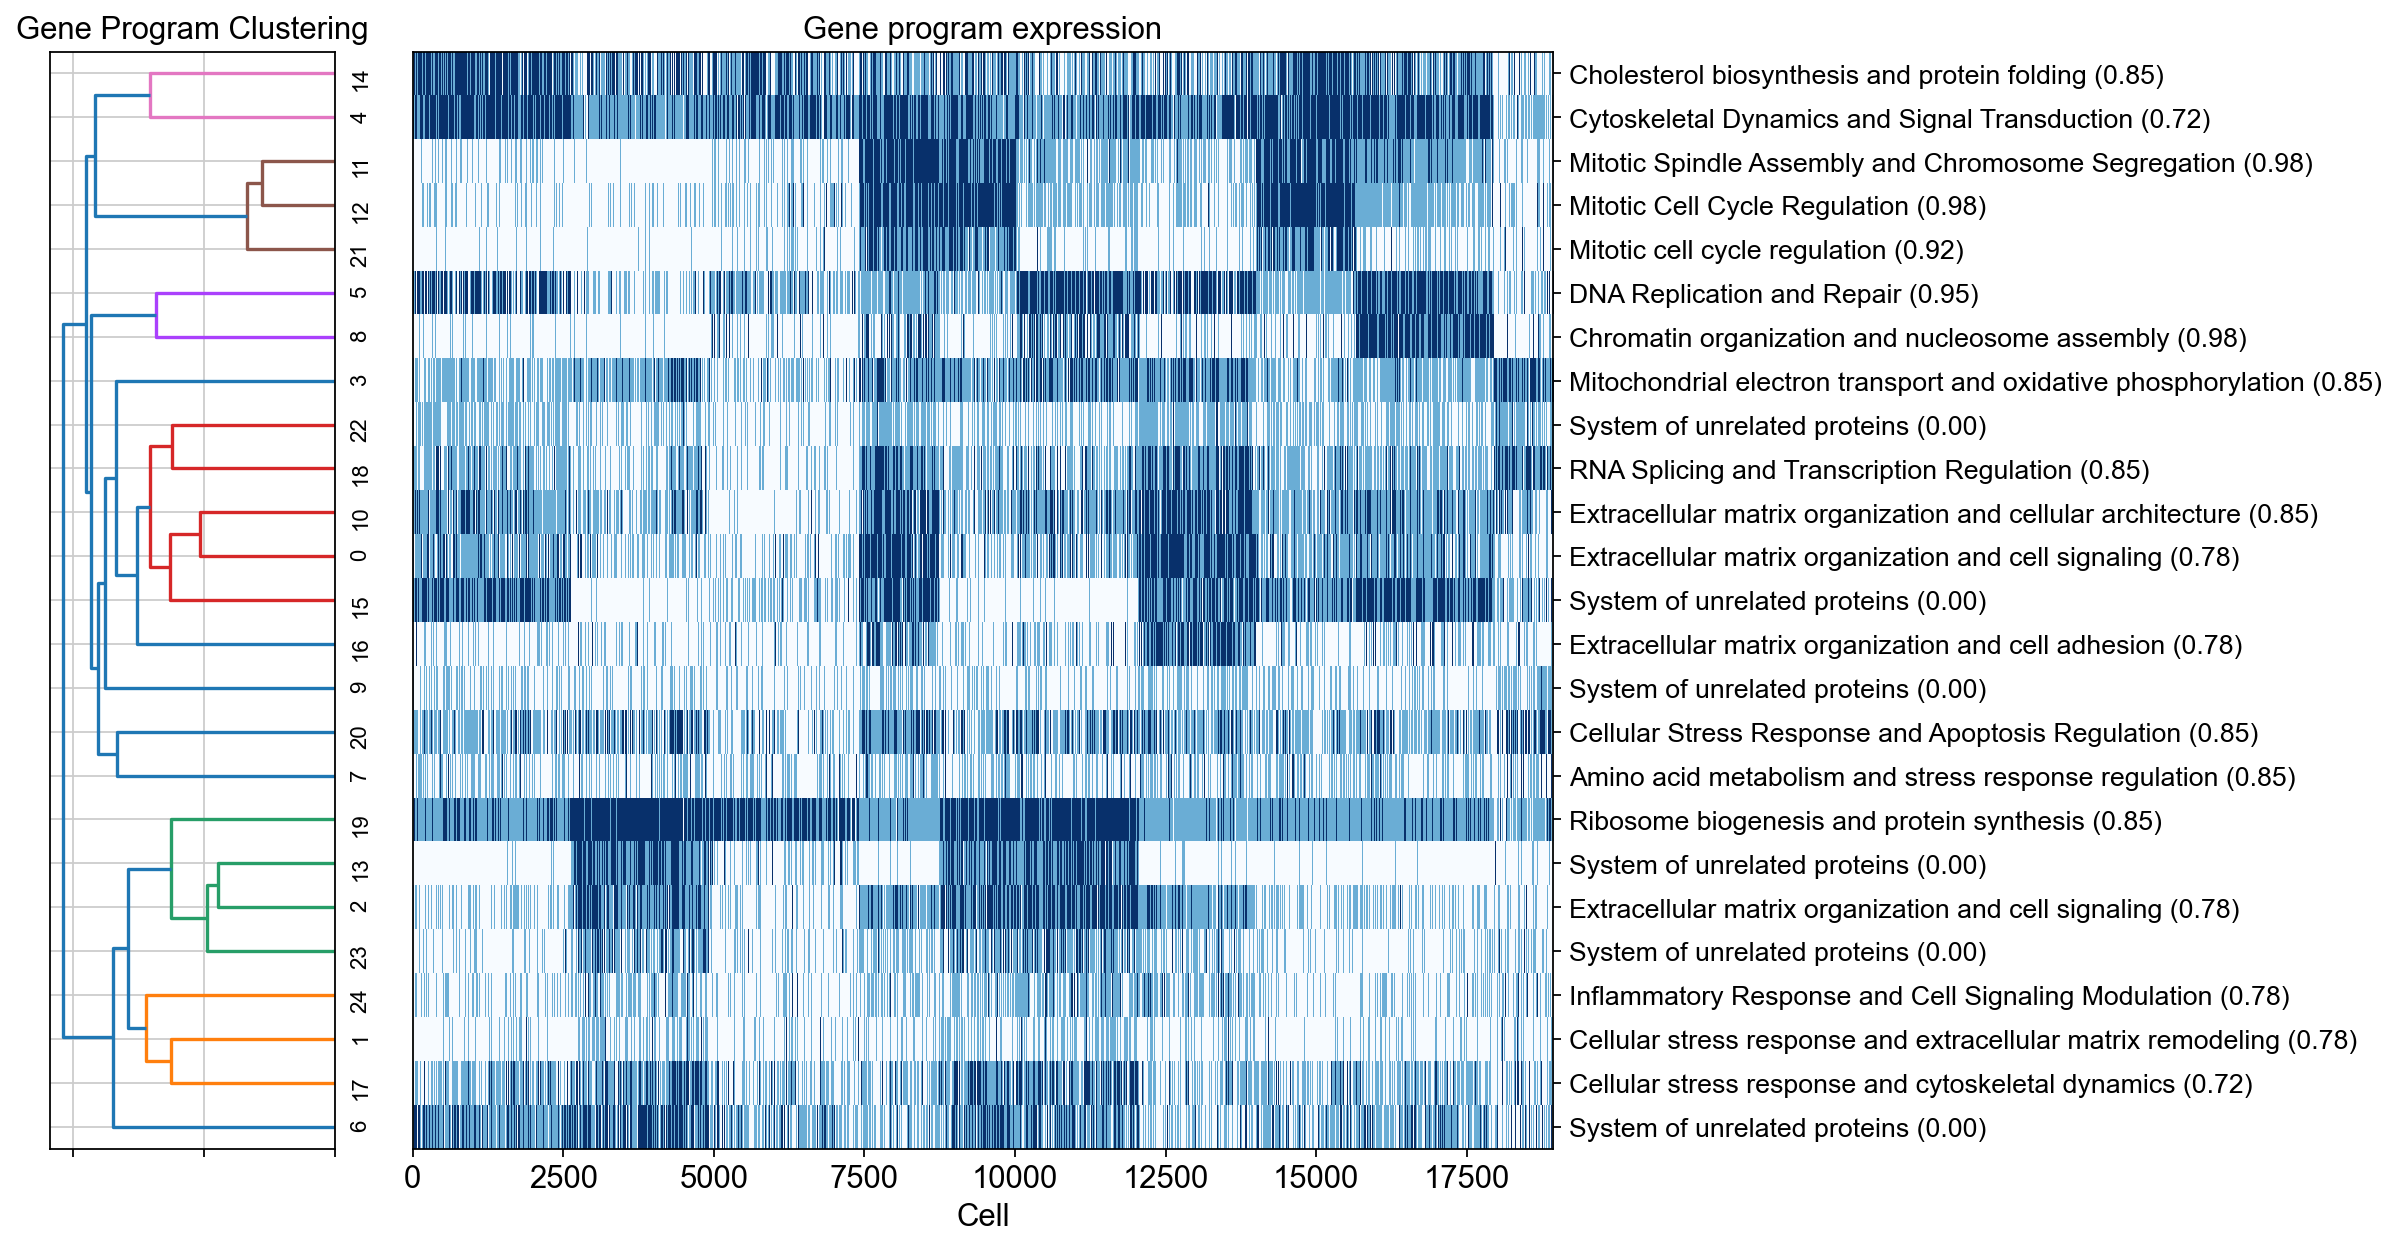

In [293]:
# Generate and save a hierarchically clustered version of the heatmap
visualize_program_expression_with_hierarchical_clustering(
    model.onmf_decomposition,
    [program_dict[str(program_number)] for program_number in range(num_gene_programs)],
    gbm43_hvg.X.toarray(),
    model.program_discretized,
    num_gene_programs=num_gene_programs,
    fig_folder=save_path + "/",
    subsample=None,
    n_clusters=10
)

'../output/gbm43/dspin/combined_oNMF_outputs/gene_program_decomposition_hierarchical.png'

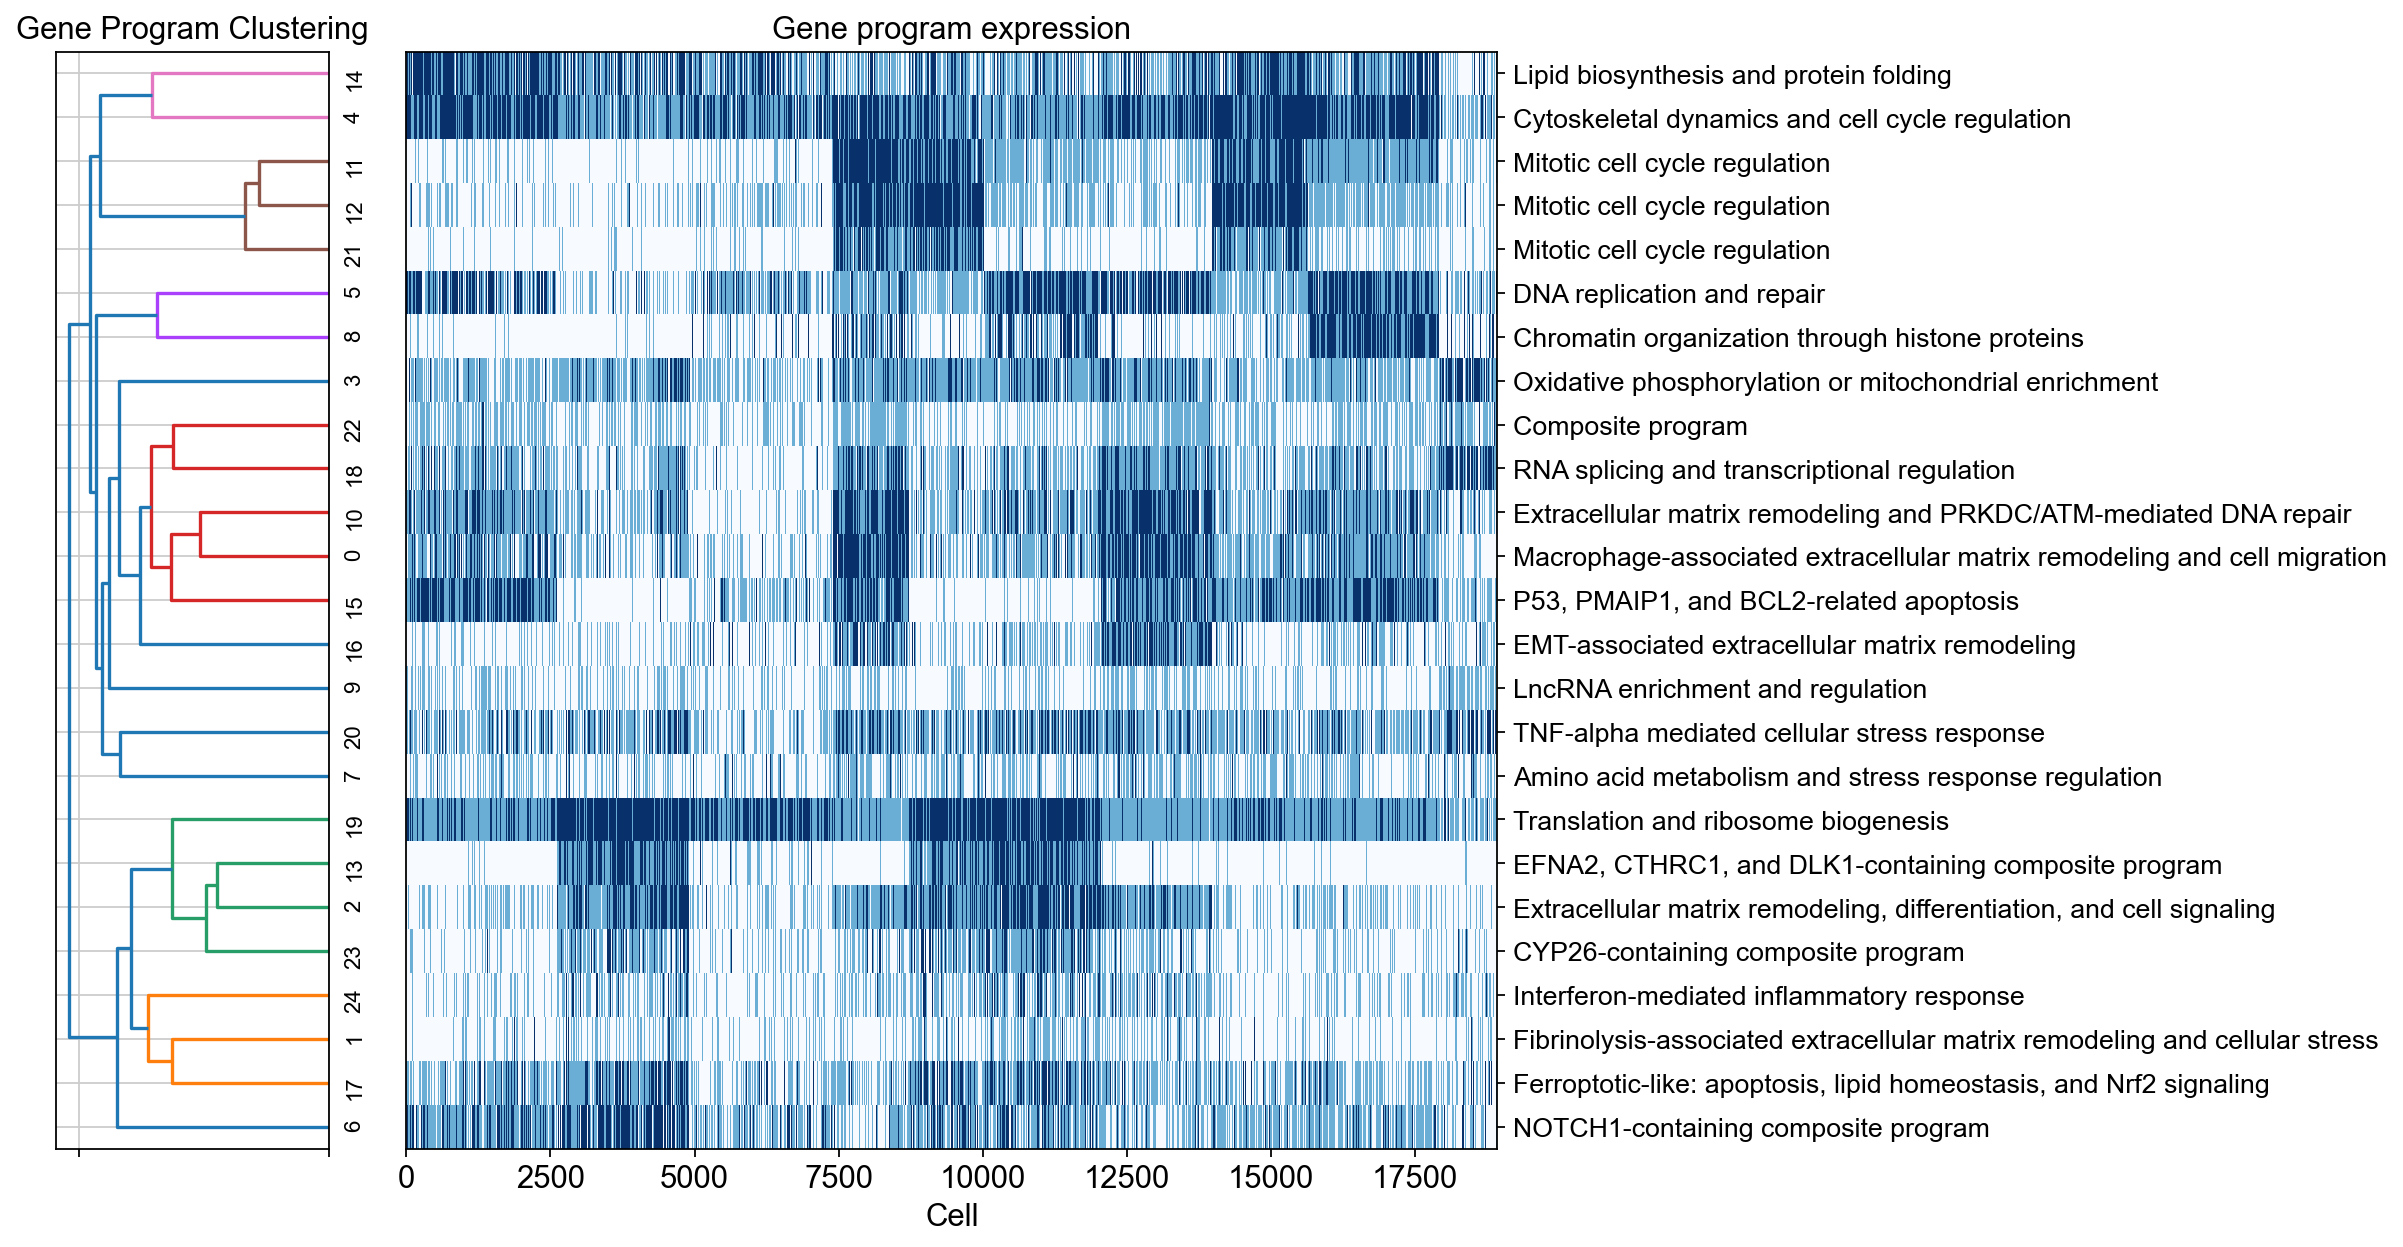

In [294]:
# Generate and save a hierarchically clustered version of the heatmap
visualize_program_expression_with_hierarchical_clustering(
    model.onmf_decomposition,
    enrichr_and_manual_gene_program_names,
    gbm43_hvg.X.toarray(),
    model.program_discretized,
    num_gene_programs=num_gene_programs,
    fig_folder=save_path + "/",
    subsample=None,
    n_clusters=10
)

In [294]:
# Save this dspin object so that we can return to it later.
with open(os.path.join(save_path, "gene_programs_0_25_25_model.pkl"), "wb") as f:
    pickle.dump(model, f)

In [289]:
with open(os.path.join(save_path, "gene_programs_0_25_25_model.pkl"), "rb") as f:
    model = pickle.load(f)

### Network inference and gene program analysis

#### Network functions

In [5]:
def read_in_model(model_file):
    with open(model_file, "rb") as f:
        return pickle.load(f)

def get_gpt_annotations(gpt_dir):
    program_dict = {}
    for file_path in glob.glob(os.path.join(gpt_dir, "*.txt")):
        with open(file_path, "r") as file:
            first_line = file.readline().strip()
            program_number: str = os.path.basename(file_path).split("_")[1].replace(".txt", "")
            program_dict[program_number] = first_line.replace("Process: ", "")
    return program_dict

def _min_max_scale_to_range(x: np.ndarray, low: int, high: int) -> np.ndarray:
    """
    Min-max scale x to the range (low, high)
    """
    x_min = x.min()
    x_max = x.max()
    min_max_scale = (x - x_min) / (x_max - x_min + 1e-10)
    scale_to_range = low + (high - low) * min_max_scale
    return scale_to_range

def plot_network_from_adjacency_matrix(
    adjacency_matrix: np.ndarray,
    positions: Optional[Dict] = None,
    labels: Optional[Dict] = None,
    elimination_range: Optional[Tuple[float, float]] = (0.1, None),
    seed: int = 0,
    node_size: int = 12,
    negative_weight_range: Optional[Tuple[float, float]] = None,
    positive_weight_range: Optional[Tuple[float, float]] = None,
    thickness_range: Tuple[int, int] = (0.5, 2),
    transparency_range: Tuple[int, int] = (0.5, 1),
    colors: Tuple[str, str] = ("#3285CC", "#E84B23"),
    edge_determination_rule: Optional[Callable[[Tuple], str]] = None
):
    """
    Given an adjacency matrix, plot its corresponding graph on the current axis. Perturbation edges and program
    edges will be plotted separately.

    Args:
        adjacency_matrix (ndarray): A matrix representation of the graph.
        positions (dict): X-y coordinates for node positions
        labels (dict): Labels for node positions
        elimination_range (tuple): If set, values below or above this range 
            will be set to 0 in the adjacency matrix.
        seed (int): For seeding positions of nodes when not assigned.
        node_size (int): The display node size.
        negative_weight_range (tuple): If set, negative edge weight values outside
            of this range will be clipped to this range.
        positive_weight_range (tuple): If set, positive edge weight values outside
            of this range will be clipped to this range.
        thickness_range (tuple): After clipping, min and max values in the
            matrix will be interpolated to this range for both negative and positive weights.
        transparency_range (tuple): After clipping, min and max values in the matrix
            will be scaled to the range with a sigmoid function.
        colors (tuple): The first color represents min value, second represents max value.
        edge_determination_rule (Callable[[Tuple], Literal["perturb", "program"]], optional): A function that takes a tuple representing 
            an edge (u, v) and returns a string indicating the type of edge. If this argument is defined, all edges will be thus classified.
    """
    # Apply the elimination range
    mat = adjacency_matrix.copy()
    if elimination_range is not None:
        min_threshold, max_threshold = elimination_range
        if min_threshold is not None:
            mat[np.abs(adjacency_matrix) < min_threshold] = 0
        if max_threshold is not None:
            mat[np.abs(adjacency_matrix) > max_threshold] = 0
    
    # Make the diagonals of the matrix zero so we don't have self-referencing edges
    np.fill_diagonal(mat, 0)

    # Construct the graph
    G = nx.from_numpy_array(mat)

    # Separate out the positive, negative, and perturbation edges
    if edge_determination_rule is not None:
        perturb_edges_with_weights = [(u, v, d) for (u, v, d) in G.edges(data=True) if d["weight"] != 0 and edge_determination_rule((u, v)) == "perturb"]
        program_edges_with_weights = [(u, v, d) for (u, v, d) in G.edges(data=True) if d["weight"] != 0 and edge_determination_rule((u, v)) == "program"]
    else:
        perturb_edges_with_weights = []
        program_edges_with_weights = [(u, v, d) for (u, v, d) in G.edges(data=True) if d["weight"] != 0]
    positive_perturb_edges = [(u, v) for (u, v, d) in perturb_edges_with_weights if d["weight"] > 0]
    positive_perturb_weights = np.array([d["weight"] for (_, _, d) in program_edges_with_weights if d["weight"] > 0])
    negative_perturb_edges = [(u, v) for (u, v, d) in perturb_edges_with_weights if d["weight"] < 0]
    negative_perturb_weights = np.array([abs(d["weight"]) for (_, _, d) in perturb_edges_with_weights if d["weight"] < 0])
    positive_program_edges = [(u, v) for (u, v, d) in program_edges_with_weights if d["weight"] > 0]
    positive_program_weights = np.array([d["weight"] for (_, _, d) in program_edges_with_weights if d["weight"] > 0])
    negative_program_edges = [(u, v) for (u, v, d) in program_edges_with_weights if d["weight"] < 0]
    negative_program_weights = np.array([abs(d["weight"]) for (_, _, d) in program_edges_with_weights if d["weight"] < 0])

    # Define the positions of the nodes if not previously defined
    if positions is None:
        positions = nx.spring_layout(G, seed=seed)

    # Clip values to the negative and positive weight ranges
    if negative_weight_range is not None:
        min_threshold, max_threshold = negative_weight_range
        negative_program_weights = np.clip(negative_program_weights, abs(min_threshold), abs(max_threshold))
        negative_perturb_weights = np.clip(negative_perturb_weights, abs(min_threshold), abs(max_threshold))
    if positive_weight_range is not None:
        min_threshold, max_threshold = positive_weight_range
        positive_program_weights = np.clip(positive_program_weights, min_threshold, max_threshold)
        positive_program_weights = np.clip(positive_perturb_weights, min_threshold, max_threshold)
    
    # Determine thickness and transparency values for the negative and positive ranges
    thickness_low, thickness_high = thickness_range
    positive_program_thicknesses = _min_max_scale_to_range(positive_program_weights, thickness_low, thickness_high) if len(positive_program_weights) > 0 else []
    negative_program_thicknesses = _min_max_scale_to_range(negative_program_weights, thickness_low, thickness_high) if len(negative_program_weights) > 0 else []
    positive_perturb_thicknesses = _min_max_scale_to_range(positive_perturb_weights, thickness_low, thickness_high) if len(positive_perturb_weights) > 0 else []
    negative_perturb_thicknesses = _min_max_scale_to_range(negative_perturb_weights, thickness_low, thickness_high) if len(negative_perturb_weights) > 0 else []

    transparency_low, transparency_high = transparency_range
    c = -np.max(np.abs(mat)) / 4
    sigmoid_function = lambda x: transparency_low + (transparency_high - transparency_low) / (1 + np.exp(-5 * x + c))
    positive_program_transparencies = sigmoid_function(positive_program_weights)
    negative_program_transparencies = sigmoid_function(negative_program_weights)
    positive_perturb_transparencies = sigmoid_function(positive_perturb_weights) if len(positive_perturb_weights) > 0 else []
    negative_perturb_transparencies = sigmoid_function(negative_perturb_weights) if len(negative_perturb_weights) > 0 else []
    
    # Plot the nodes and edges
    ax = plt.gca()
    nx.draw_networkx_nodes(G, positions, ax=ax, node_size=node_size, node_color="#a47f6e", edgecolors="black")
    # if labels is not None:
    #     nx.draw_networkx_labels(G, positions, labels=labels, font_size=10, verticalalignment="baseline")
    if labels is not None:
        for node, label in labels.items():
            x, y = positions[node]
            text = ax.text(
                x, y - 0.2, label, fontsize=10, ha='center', va='center', color='black', fontweight="bold"
                # path_effects=[
                #     path_effects.Stroke(linewidth=2, foreground='white'),  # White outline
                #     path_effects.Normal()  # Normal black text
                # ]
            )
    nx.draw_networkx_edges(G, positions, ax=ax, edgelist=positive_program_edges, width=positive_program_thicknesses,
                           edge_color=colors[1], alpha=positive_program_transparencies)
    nx.draw_networkx_edges(G, positions, ax=ax, edgelist=negative_program_edges, width=negative_program_thicknesses,
                           edge_color=colors[0], alpha=negative_program_transparencies)
    nx.draw_networkx_edges(G, positions, ax=ax, edgelist=positive_perturb_edges, width=positive_perturb_thicknesses,
                           edge_color=RED, alpha=positive_perturb_transparencies)
    nx.draw_networkx_edges(G, positions, ax=ax, edgelist=negative_perturb_edges, width=negative_perturb_thicknesses,
                        edge_color=BLUE, alpha=negative_perturb_transparencies)
    ax.set_axis_off()
    return positions, positive_program_weights, negative_program_weights

def partition_adjacency_matrix(
    adjacency_matrix: np.ndarray,
    elimination_threshold: int = 0,
    partitioning_resolution: int = 2,
    seed: int = 0
) -> list[list[int]]:
    """
    Given some adjacency matrix where its indices represent nodes,
    partition the nodes at a set resolution and return the partitioned groups.

    Notes:
        Partitions the positive and negative subedges separately.
    """
    # Eliminate based on elimination threshold
    mat = adjacency_matrix.copy()
    mat[np.abs(mat) < elimination_threshold] = 0

    # Set the diagonal to 0 so we don't have self-referencing edges
    np.fill_diagonal(mat, 0)

    # Generate a graph from the adjacency matrix
    G = ig.Graph.Weighted_Adjacency(mat.tolist())
    G_pos = G.subgraph_edges(G.es.select(weight_gt=0), delete_vertices=False)
    G_neg = G.subgraph_edges(G.es.select(weight_lt=0), delete_vertices=False)
    G_neg.es["weight"] = [abs(w) for w in G_neg.es["weight"]]

    # Partition the graph into clusters
    part_pos = la.RBConfigurationVertexPartition(G_pos, weights='weight', resolution_parameter=partitioning_resolution)
    part_neg = la.RBConfigurationVertexPartition(G_neg, weights='weight', resolution_parameter=partitioning_resolution)
    optimiser = la.Optimiser()
    optimiser.set_rng_seed(seed)

    # Note that this optimizer modifies the partitions in place, balancing
    # the positive partitions with 1 and negative partitions with -1
    optimiser.optimise_partition_multiplex(
        [part_pos, part_neg],
        layer_weights=[1,-1]
    )
    network_partitions = list(part_pos)
    return network_partitions

def extract_h_matrix(control_perturb: str, model):
    """
    Extract an h matrix that has control column deleted. This function
    does not change the model passed in in place.

    Returns:
        control_perturb: A string value that was used for relative response calculations.
        model: A D-SPIN model object that has relative responses and a sample list.
    """
    rel_h = model.relative_responses.copy()
    perturb_names = model.sample_list.copy()
    rel_h += 1e-6
    
    control_index = np.where(perturb_names == control_perturb)[0][0]
    rel_h = np.delete(rel_h, control_index, axis=1)
    perturb_names = np.delete(perturb_names, control_index)
    return rel_h, perturb_names

#### Network inference

In [36]:
model = read_in_model(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "gene_programs_0_25_25_model.pkl"))
# program_names = get_gpt_annotations(os.path.join(save_path, "gene_programs_0_30_30_gpt"))
program_names = {str(i): enrichr_and_manual_gene_program_names[i] for i in range(len(enrichr_and_manual_gene_program_names))}

In [37]:
# Filter out sgRNAs that we don't want: either ones that have bad knockdown or ones that do not pass
# our coverage filter of more than 5 cells
samples = gbm43_hvg.obs['sgRNA'].unique().tolist()
bad_knockdown = ['OVCH1', 'GRAMD4', 'FBXL16'] # Determined from previous knockdown or off-target effects
samples = [sample for sample in samples if sample not in bad_knockdown]

sample_counts = gbm43_hvg.obs['sgRNACond'].value_counts()
bad_coverage = sample_counts[sample_counts <= 5]
print(bad_coverage)
bad_coverage = ['NUP205', 'CDCA5']
samples = [sample for sample in samples if sample not in bad_coverage]
RT_samples = [sample + '_RT' for sample in samples]
noRT_samples = [sample + '_noRT' for sample in samples]

NUP205_noRT    4
CDCA5_noRT     3
Name: sgRNACond, dtype: int64


In [38]:
# Create two separate models
RT_model = copy.deepcopy(model)
noRT_model = copy.deepcopy(model)
RT_noRTNormalized_model = copy.deepcopy(model)

In [39]:
RT_model.network_inference(
    sample_col_name="sgRNACond",
    method="pseudo_likelihood",
    example_list=RT_samples,
    params={"stepsz": 0.05, "num_epoch": 200}
)
sample_list = RT_model.sample_list
if_control = np.array([samp == "non-targeting_RT" for samp in sample_list])
batch_index = np.array([1 for samp in sample_list]) # Assume all part of one batch for now
RT_model.response_relative_to_control(if_control, batch_index)

Using pseudo_likelihood for network inference.
Regularization parameters
lambda_l1_j: 0.01
lambda_l2_h: 0.005


100%|██████████| 200/200 [00:10<00:00, 18.19it/s, Network Gradient=2.6692]

153


In [40]:
with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "RT_model.pkl"), "wb") as f:
    pickle.dump(RT_model, f)

In [41]:
RT_noRTNormalized_model.network_inference(
    sample_col_name="sgRNACond",
    method="pseudo_likelihood",
    example_list=RT_samples + ["non-targeting_noRT"],
    params={"stepsz": 0.05, "num_epoch": 200}
)
sample_list = RT_noRTNormalized_model.sample_list
if_control = np.array([samp == "non-targeting_noRT" for samp in sample_list])
batch_index = np.array([1 for samp in sample_list]) # Assume all part of one batch for now
RT_noRTNormalized_model.response_relative_to_control(if_control, batch_index)

Using pseudo_likelihood for network inference.
Regularization parameters
lambda_l1_j: 0.01
lambda_l2_h: 0.005


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:08<00:00, 24.11it/s, Network Gradient=2.8136]

153


In [90]:
RT_noRTNormalized_model.sample_list

array(['ATRIP_RT', 'BORA_RT', 'C20orf196_RT', 'CAMKK2_RT', 'CCT6A_RT',
       'CENPJ_RT', 'DDOST_RT', 'DNAJC17_RT', 'EIF2B2_RT', 'ERCC6L2_RT',
       'GKAP1_RT', 'MED17_RT', 'MMS22L_RT', 'POLD3_RT', 'POLR2C_RT',
       'PRKDC_RT', 'RBM42_RT', 'RBX1_RT', 'RIF1_RT', 'RNF8_RT',
       'RPLP0_RT', 'RRN3_RT', 'SFPQ_RT', 'SLC39A7_RT', 'TFIP11_RT',
       'non-targeting_RT', 'CCT7_RT', 'CENPT_RT', 'DHX16_RT', 'LRR1_RT',
       'PSMC5_RT', 'non-targeting_noRT'], dtype=object)

In [42]:
with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "RT_noRTNorm_model.pkl"), "wb") as f:
    pickle.dump(RT_noRTNormalized_model, f)

In [86]:
noRT_model.network_inference(
    sample_col_name="sgRNACond",
    method="pseudo_likelihood",
    example_list=noRT_samples,
    params={"stepsz": 0.05, "num_epoch": 200}
)
sample_list = noRT_model.sample_list
if_control = np.array([samp == "non-targeting_noRT" for samp in sample_list])
batch_index = np.array([1 for samp in sample_list]) # Assume all part of one batch for now
noRT_model.response_relative_to_control(if_control, batch_index)

Using pseudo_likelihood for network inference.
Regularization parameters
lambda_l1_j: 0.01
lambda_l2_h: 0.005


100%|██████████| 200/200 [00:03<00:00, 58.09it/s, Network Gradient=4.3324]

184


In [44]:
with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "noRT_model.pkl"), "wb") as f:
    pickle.dump(noRT_model, f)

#### Single-model visualization
Note: the model should not be modified. Make copies of all objects

In [21]:
num_gene_programs = 25
with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "noRT_model.pkl"), "rb") as f:
    model = pickle.load(f)
with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "enrichr_and_manual_gene_program_names_dict.pkl"), "rb") as f:
    enrichr_and_manual_gene_program_names_dict = pickle.load(f)
enrichr_and_manual_gene_program_names = [enrichr_and_manual_gene_program_names_dict[i] for i in range(num_gene_programs)]
program_names = {str(i): enrichr_and_manual_gene_program_names_dict[i] for i in range(len(enrichr_and_manual_gene_program_names_dict))}

SAVE_PATH = os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "noRT_model")
CONTROL_PERTURB = "non-targeting_noRT"
cur_j = model.network.copy()
cur_h = model.responses.copy()

In [22]:
# Because there's only one control sample and we don't want to end up with a constant vector, add
# a very small number to the entire matrix.
rel_h, perturb_names = extract_h_matrix(CONTROL_PERTURB, model)

In [23]:
# Visualize the J matrix, which shows associations between programs
plt.figure(figsize=(6, 6))
plt.xticks(ticks=np.arange(len(program_names)), labels=list(program_names.values()), rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(len(program_names)), labels=list(program_names.values()), fontsize=8)
plt.imshow(np.triu(cur_j), cmap=CMAP_HVEC, vmin=-1, vmax=1)
plt.colorbar()
plt.xlim(0, len(program_names))  # Limit x-axis to show only the upper triangle
plt.ylim(0, len(program_names))  # Limit y-axis to show only the upper triangle
plt.savefig(os.path.join(SAVE_PATH, "upper_triangle_j_matrix.pdf"), format='pdf')

In [24]:
# Perform hierarchical clustering on the perturbation vectors
perturbation_linkage = linkage(rel_h.T, method='average', metric='correlation', optimal_ordering=True)
program_linkage = linkage(rel_h, method="average", metric="correlation", optimal_ordering=True)
perturbation_order = dendrogram(perturbation_linkage, no_plot=True)["leaves"][::-1]
program_order = dendrogram(program_linkage, no_plot=True)["leaves"][::-1]

In [25]:
# Visualize the perturbation vectors, which show how each perturbation affects each of
# the gene programs.
fig = plt.figure(figsize=(10, 10))
gs = plt.GridSpec(1, 2, width_ratios=[1, 4], height_ratios=[1])
ax_dendr = fig.add_subplot(gs[0, 0])
dendrogram(perturbation_linkage, leaf_rotation=90, orientation="left", no_labels=False)
ax_dendr.set_xticklabels([])
plt.title('Response Vector Clustering')
ax_prog = fig.add_subplot(gs[0, 1])
plt.imshow(rel_h.T[perturbation_order, :][:, program_order],
            aspect='auto', cmap=CMAP_HVEC, vmin=-2, vmax=2)
plt.yticks(range(rel_h.shape[1]), [perturb_names[i] for i in perturbation_order], fontsize=12)
plt.xticks(range(rel_h.shape[0]), [f"P-{i}" for i in program_order], fontsize=12, rotation=90)
plt.gca().yaxis.set_ticks_position('right')
plt.xlabel('Program')
plt.ylabel("Perturbation")
plt.title('Perturbation vectors')
plt.colorbar(shrink=0.1, anchor=(1.1, 0.0))
plt.grid()

# Save the figure as a PDF
plt.savefig(os.path.join(SAVE_PATH, "perturbation_programs_heatmap.pdf"), format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.clf()

In [26]:
# Construct the regulatory network visualization by partitioning the graph
program_partitions = partition_adjacency_matrix(
    cur_j
)
partition_program_order = [program for cluster_of_programs in list(program_partitions) for program in cluster_of_programs]
partition_program_names = [f"P-{i}" for i in partition_program_order]
program_partition_lengths = [len(cur_list) for cur_list in list(program_partitions)]

In [27]:
# Visualize how the clusters relate to each other
plt.figure(figsize=(10, 6))

plt.imshow(cur_j[:, partition_program_order][partition_program_order, :], cmap=CMAP_HVEC, vmin=- 1, vmax=1)
for ii in range(len(program_partition_lengths)):
    plt.axhline(np.sum(program_partition_lengths[:ii]) - 0.5, color='k', linewidth=1)
    plt.axvline(np.sum(program_partition_lengths[:ii]) - 0.5, color='k', linewidth=1)

# plt.xticks(np.cumsum(net_class_len) - np.array(net_class_len) / 2 - 0.5, net_class_name, rotation=90)
# plt.yticks(np.cumsum(net_class_len) - np.array(net_class_len) / 2 - 0.5, net_class_name)
plt.xticks(np.arange(len(partition_program_order)), np.array(partition_program_names), rotation=90, fontsize=12)
plt.yticks(np.arange(len(partition_program_order)), np.array(partition_program_names), fontsize=12)
plt.colorbar()
plt.grid()

plt.title('Regulatory network')
plt.savefig(os.path.join(SAVE_PATH, "program_partition_correlations.pdf"), format = "pdf")
plt.clf()

In [28]:
program_umap_pos = assign_program_position(model.program_representation, gbm43_hvg.obsm["X_umap"], repulsion=4)

In [29]:
# Plot the gene network
# Set positions from the UMAP:
positions = {
    i: [program_umap_pos[i, 0], program_umap_pos[i, 1]] for i in range(model.program_representation.shape[1])
}
labels = {i: f"P-{i}" for i in range(model.program_representation.shape[1])}

# Create figure with extra space on the right for legends
fig, ax = plt.subplots(figsize=(16, 12))

negative_weight_range = (0.1, 1)
positive_weight_range = (0.1, 1)
thickness_range = (0.5, 2)
transparency_range = (0.3, 1)

sc.pl.umap(gbm43_hvg, color="leiden_1.0", ax=ax, show=False, size=15, alpha=0.7, legend_loc="best", add_outline=False)
positions, positive_program_weights, negative_program_weights = plot_network_from_adjacency_matrix(
    cur_j,
    positions=positions,
    labels=labels,
    elimination_range=(0.1, None),
    negative_weight_range=negative_weight_range,
    positive_weight_range=positive_weight_range,
    thickness_range=thickness_range,
    transparency_range=transparency_range,
    node_size=80
)

# Populate program legends
program_legend_elements = []
for i in range(num_gene_programs):
    program_label = labels[i]
    program_name = program_names[str(i)]
    program_legend_elements.append(
        plt.Line2D(
            [0], [0], marker="o", color="white", markerfacecolor="black",
            markersize=5, label=f"{program_label}: {program_name}"
        )
    )

# Populate line_thickness_legend_elements
line_thickness_legend_elements = []
thicknesses = [thickness_range[1], thickness_range[0], thickness_range[0], thickness_range[1]]
transparencies = [transparency_range[1], transparency_range[0], transparency_range[0], transparency_range[1]]
edge_weights = [positive_weight_range[1], positive_weight_range[0], -negative_weight_range[0], -negative_weight_range[1]]
colors = [RED, RED, BLUE, BLUE]
for thickness, transparency, edge_weight, color in zip(thicknesses, transparencies, edge_weights, colors):
    line_thickness_legend_elements.append(plt.Line2D(
        [0], [0], color=color, linewidth=thickness, alpha=transparency, solid_capstyle="round",
        label=f"Weight: {edge_weight:.2f}"
    ))

# Combine all legend elements
all_legend_elements = program_legend_elements + [plt.Line2D([0], [0], color='none', label=' ')] + line_thickness_legend_elements

# Create a single legend with all elements
ax.legend(handles=all_legend_elements,
         bbox_to_anchor=(0.8, 1),
         loc='upper left',
         frameon=True,
         labelspacing=0.2,
         handletextpad=0.3,
         borderpad=0.3,
         markerscale=0.7,
         fontsize=8)

ax.set_title("noRT program network")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, "program_network.pdf"), format="pdf", backend="cairo")

In [30]:
# Generate perturbation partitions along with graph partitions
mat = cur_j.copy()
rel_h = model.relative_responses.copy()
num_gene_programs = model.program_representation.shape[1]
num_perturb = len(perturb_names)

In [31]:
# Prepare the matrix for partitioning
np.fill_diagonal(mat, 0)

# Construct the graph representation of the adjacency matrix, with perturbation links
G = ig.Graph.Weighted_Adjacency(mat.tolist(), mode="UNDIRECTED", attr="weight")
for idx, perturb_name in enumerate(perturb_names):
    G.add_vertex(name=perturb_name)
    for spin in range(num_gene_programs):
        if abs(rel_h[spin, idx]) > 0:
            G.add_edge(perturb_name, spin, weight=rel_h[spin, idx])

# Split the graph into positive and negative subgraphs for partitioning
G_positive = G.subgraph_edges(G.es.select(weight_gt = 0), delete_vertices=False)
G_negative = G.subgraph_edges(G.es.select(weight_lt = 0), delete_vertices=False)
G_negative.es["weight"] = [-w for w in G_negative.es["weight"]]

# Prepare a data structure to hold partition results. The values of membership_array
# indicate which cluster each item belongs to.
membership_array = np.zeros(num_gene_programs, dtype=int)

# Add the existing network partitions to the partition results array
for idx, class_list in enumerate(program_partitions):
    membership_array[class_list] = idx
membership_list = list(membership_array)
membership_list += [np.max(membership_list) + 1] * num_perturb

# Generate partitions for these communities
optimization_mask = [True] * num_gene_programs + [False] * num_perturb

# Initialize partitions of the graph
positive_partition = la.RBConfigurationVertexPartition(
    G_positive,
    weights="weight",
    resolution_parameter=3,
    initial_membership=membership_list
)
negative_partition = la.RBConfigurationVertexPartition(
    G_negative,
    weights="weight",
    resolution_parameter=3,
    initial_membership=membership_list
)

# Initialize an optimizer. Note that this partition is done in place
optimiser = la.Optimiser()
optimiser.set_rng_seed(0)
diff = optimiser.optimise_partition_multiplex(
    [positive_partition, negative_partition],
    is_membership_fixed=optimization_mask,
    n_iterations=-1,
    layer_weights=[1, -1]
)

# Extract the perturbation partitions from the partition objects
perturbation_partition_lists = []
for partition_list in positive_partition:
    partition_list = [idx - num_gene_programs for idx in partition_list if idx >= num_gene_programs]
    if len(partition_list) > 0:
        perturbation_partition_lists.append(partition_list)

# Extract the mean intensity of perturbations
mean_intensity = np.zeros(len(perturbation_partition_lists))
for idx, partition_list in enumerate(perturbation_partition_lists):
    mean_intensity[idx] = np.mean(np.abs(rel_h[:, partition_list]))
perturbation_partition_lists = np.array(perturbation_partition_lists, dtype=list)[np.argsort(mean_intensity)]
perturbation_order = [idx for partition_list in perturbation_partition_lists for idx in partition_list]
perturbation_partition_lengths = [len(partition_list) for partition_list in perturbation_partition_lists]

In [32]:
# Plot the resulting partitions
fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(rel_h.T[:, partition_program_order][perturbation_order, :], cmap=CMAP_HVEC, vmin=-2, vmax=2, aspect='auto')
plt.yticks(np.arange(len(perturb_names)), np.array(perturb_names)[perturbation_order], fontsize=10)
plt.xticks(np.arange(len(partition_program_order)), np.array(partition_program_names), fontsize=12, rotation=90)
plt.grid()

for ii in range(len(program_partition_lengths)):
    plt.axvline(np.sum(program_partition_lengths[:ii]) - 0.5, color='k', linewidth=1)
for i in range(len(perturbation_partition_lengths)):
    plt.axhline(np.sum(perturbation_partition_lengths[:i]) - 0.5, color='k', linewidth=1)
plt.savefig(os.path.join(SAVE_PATH, "program_perturbation_partitions.pdf"), format="pdf", backend="cairo")

In [33]:
RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS = ["BORA", "C20orf196", "CAMKK2", "ERCC6L2", "RNF8", "ATRIP", "CCT6A", "CCT7", "DNAJC17", "MMS22L", "TFIP11", "LRR1", "GKAP1", "DDOST"]
RT_DEPENDENT_PERTURBATIONS = ["CENPT", "PRKDC", "RIF1"]
RT_INDEPENDENT_CLUSTERED_PERTURBATIONS = ["MED17", "SFPQ", "CENPJ", "DHX16", "EIF2B2", "POLD3", "POLR2C", "PSMC5", "RBX1", "RPLP0", "RBM42", "RRN3", "SLC39A7"]
RT_INDEPENDENT_CLUSTERED_SUBSET = ["MED17", "SFPQ", "RPLP0", "RBX1"]

In [36]:
# Plot the perturbations effects on the network, superimposed on a UMAP plot.
mat = model.network.copy()
# mat = np.zeros(model.network.shape)
PERTURBS_OF_INTEREST = [gene + "_noRT" for gene in RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS]
title = "RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS"

# Generate positions and labels for the original network
num_gene_programs = model.program_representation.shape[1]
positions = {
    i: [program_umap_pos[i, 0], program_umap_pos[i, 1]] for i in range(num_gene_programs)
}
labels = {i: f"P-{i}" for i in range(num_gene_programs)}

# Extend the adjacency matrix with the perturbations. Note that we maintain squareness,
# and model interactions between perturbations as zero (they only interact with the original network).
num_selected_perturbations = len(PERTURBS_OF_INTEREST)
indices_of_perturbations = []
for perturb in PERTURBS_OF_INTEREST:
    arg_index = np.where(perturb_names == perturb)[0][0]
    indices_of_perturbations.append(arg_index)
rel_h_subset_scale = rel_h[:, indices_of_perturbations].clip(-1, 1)
mat = np.block([[mat, rel_h_subset_scale], [rel_h_subset_scale.T, np.zeros((num_selected_perturbations, num_selected_perturbations))]])

# Get the length of each class of perturbation
selected_perturbation_partition_lengths = [len([x for x in group if x in indices_of_perturbations]) for group in list(perturbation_partition_lists)]

# If all the lengths are the same, just put them all in one group
if sum(selected_perturbation_partition_lengths) == 0:
    selected_perturbation_partition_lengths = [num_selected_perturbations]

# Construct positions for the perturbations
start_angle = 0.05 * np.pi
end_angle = 0.95 * np.pi
gap_size = 2 # Each gap takes up the space of 2 perturbations

# Calculate the total number of angles needed
total_angles = num_selected_perturbations + gap_size * (len(selected_perturbation_partition_lengths) - 1)

# Generate a raw angle list
angle_list_raw = np.linspace(start_angle, end_angle, total_angles)

# Initialize a list to hold the final angles
cumulative_group_sizes = cumulative_group_sizes = np.cumsum(selected_perturbation_partition_lengths)
cumulative_group_sizes = np.insert(cumulative_group_sizes, 0, 0)

# Select some portion of the angles to reflect the gaps.
angle_list = []
for i in range(len(selected_perturbation_partition_lengths)):
    start_index = cumulative_group_sizes[i] + gap_size * i
    end_index = cumulative_group_sizes[i + 1] + gap_size * i
    angle_list.extend(angle_list_raw[start_index:end_index])

# Arrange the perturbations on the plot centered at some (x, y), with a distance
# of 10 away from it.
perturbation_center = (3, 8)
perturbation_distance = 8
perturbation_positions = np.array([
    perturbation_center[0] - perturbation_distance * np.cos(angle_list),
    perturbation_center[1] + perturbation_distance * np.sin(angle_list)
]).T

# Add the perturbations to the existing positions and add the labels to the
# samples.
for i, perturb in enumerate(np.array(perturb_names)[indices_of_perturbations]):
    positions[num_gene_programs + i] = [perturbation_positions[i, 0], perturbation_positions[i, 1]]
    labels[num_gene_programs + i] = perturb

# Create figure with extra space on the right for legends
fig, ax = plt.subplots(figsize=(16, 16))

sc.pl.umap(gbm43_hvg, color="leiden_1.0", ax=ax, show=False, size=15, alpha=0.5, legend_loc="best", add_outline=False)
negative_weight_range = (0.1, 0.8)
positive_weight_range = (0.1, 0.8)
thickness_range = (0.2, 2)
transparency_range = (0.3, 0.7)

# Define a function that 
def perturb_determination_function(edge):
    return "perturb" if edge[0] > num_gene_programs - 1 or edge[1] > num_gene_programs - 1 else "program"

positions, positive_program_weights, negative_program_weights = plot_network_from_adjacency_matrix(
    mat,
    positions=positions,
    labels=labels,
    elimination_range=(0.1, None),
    negative_weight_range=negative_weight_range,
    positive_weight_range=positive_weight_range,
    thickness_range=thickness_range,
    transparency_range=transparency_range,
    node_size=80,
    edge_determination_rule=perturb_determination_function
)

# Populate program legends
program_legend_elements = []
for i in range(num_gene_programs):
    program_label = labels[i]
    program_name = program_names[str(i)]
    program_legend_elements.append(
        plt.Line2D(
            [0], [0], marker="o", color="white", markerfacecolor="black",
            markersize=5, label=f"{program_label}: {program_name}"
        )
    )

# Populate line_thickness_legend_elements
line_thickness_legend_elements = []
thicknesses = [thickness_range[1], thickness_range[0], thickness_range[0], thickness_range[1]]
transparencies = [transparency_range[1], transparency_range[0], transparency_range[0], transparency_range[1]]
edge_weights = [positive_weight_range[1], positive_weight_range[0], -negative_weight_range[0], -negative_weight_range[1]]
colors1 = [RED, RED, BLUE, BLUE]
colors2 = [GREEN, GREEN, PURPLE, PURPLE]
for thickness, transparency, edge_weight, color in zip(thicknesses, transparencies, edge_weights, colors1):
    line_thickness_legend_elements.append(plt.Line2D(
        [0], [0], color=color, linewidth=thickness, alpha=transparency, solid_capstyle="round",
        label=f"Weight: {edge_weight:.2f}"
    ))
for thickness, transparency, edge_weight, color in zip(thicknesses, transparencies, edge_weights, colors2):
    line_thickness_legend_elements.append(plt.Line2D(
        [0], [0], color=color, linewidth=thickness, alpha=transparency, solid_capstyle="round",
        label=f"Weight: {edge_weight:.2f}"
    ))

# Combine all legend elements
all_legend_elements = program_legend_elements + [plt.Line2D([0], [0], color='none', label=' ')] + line_thickness_legend_elements

# Create a single legend with all elements
ax.legend(handles=all_legend_elements,
         bbox_to_anchor=(0.8, 1),
         loc='upper left',
         frameon=True,
         labelspacing=0.2,
         handletextpad=0.3,
         borderpad=0.3,
         markerscale=0.7,
         fontsize=8)

ax.set_title(f"{title} network with perturbation edges only")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, f"perturbation_network_{title}.pdf"), format='pdf')

### Dual-model analysis

In [229]:
with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "RT_noRTNorm_model.pkl"), "rb") as f:
    RT_noRTNormalized_model = pickle.load(f)

with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "noRT_model.pkl"), "rb") as f:
    noRT_model = pickle.load(f)

with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "enrichr_and_manual_gene_program_names_dict.pkl"), "rb") as f:
    enrichr_and_manual_gene_program_names_dict = pickle.load(f)

SAVE_PATH = os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "dual_model_analysis_RTnoRTNorm_noRT")

#### Comparing perturbation effects
We can start with generating a difference matrix after eliminating nonexistent edges. We can then class the edges into a bunch of types:
- Sign-flipped (either positive to negative or vice versa)
- Magnitude change
- Completely new in RT
- Removed in RT

In [230]:
# Extract the necessary perturbation matrices
rel_h_RT, perturb_names_RT = extract_h_matrix("non-targeting_noRT", RT_noRTNormalized_model)
rel_h_noRT, perturb_names_noRT = extract_h_matrix("non-targeting_noRT", noRT_model)

# Make sure that both are in the same order, so that we can do an appropriate matrix to matrix comparison
# First, remove the "non-targeting_RT" column from the RT matrix
RT_control_index = np.where(perturb_names_RT == "non-targeting_RT")[0][0]
RT_control_vector = rel_h_RT[:, RT_control_index]
perturb_names_RT = np.delete(perturb_names_RT, RT_control_index)
sorted_indices_RT = np.argsort(perturb_names_RT)
perturb_names_RT = perturb_names_RT[sorted_indices_RT]
rel_h_RT = rel_h_RT[:, sorted_indices_RT]

sorted_indices_noRT = np.argsort(perturb_names_noRT)
perturb_names_noRT = perturb_names_noRT[sorted_indices_noRT]
rel_h_noRT = rel_h_noRT[:, sorted_indices_noRT]

# Define the program names
program_names = {str(i): enrichr_and_manual_gene_program_names_dict[i] for i in range(len(enrichr_and_manual_gene_program_names_dict.values()))}
program_p_names = [f"P-{i}" for i in range(len(program_names.values()))]
program_combined_names = [f"P-{i}: {enrichr_and_manual_gene_program_names_dict[i]}" for i in range(len(program_names.values()))]

# Define the perturb names
perturb_names = np.array([name.replace("_noRT", "") for name in perturb_names_noRT])

# Extract the difference matrix
diff = rel_h_RT - rel_h_noRT

In [231]:
# Define perturbation groups
RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS = ["BORA", "C20orf196", "CAMKK2", "ERCC6L2", "RNF8", "ATRIP", "CCT6A", "CCT7", "DNAJC17", "MMS22L", "TFIP11", "LRR1"]
RT_DEPENDENT_PERTURBATIONS = ["CENPT", "PRKDC", "RIF1"]
RT_INDEPENDENT_CLUSTERED_PERTURBATIONS = ["MED17", "SFPQ", "CENPJ", "DHX16", "DDOST", "EIF2B2", "GKAP1", "POLD3", "POLR2C", "PSMC5", "RBX1", "RPLP0", "RBM42", "RRN3", "SLC39A7"]

In [232]:
# Plot a histogram of the values overall
sc.set_figure_params(figsize=[3, 3])
plt.hist(diff.flatten(), bins=50)
plt.title("RT - noRT, all perturbations")
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, f"diff_histogram_all.pdf"), format='pdf')
plt.show()

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_83279/3803270005.py:7: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [233]:
# Plot histograms of the difference values, but grouped by perturbation
titles = ["RT_dependent", "RT_independent_clustered", "RT_independent_distributed"]
for perturbation_group, title in zip([RT_DEPENDENT_PERTURBATIONS, RT_INDEPENDENT_CLUSTERED_PERTURBATIONS, RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS], titles):
    indices = [np.where(perturb_names == perturb)[0][0] for perturb in perturbation_group]
    print(indices)
    diff_subset = diff[:, indices]
    sc.set_figure_params(figsize=[3, 3])
    plt.hist(diff_subset.flatten(), bins=30)
    plt.title(f"RT - noRT, {title}")
    plt.savefig(os.path.join(SAVE_PATH, f"diff_histogram_{title}.pdf"), format='pdf')
    plt.show()

[7, 19, 23]


/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_83279/973932985.py:11: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


[15, 27, 6, 9, 8, 11, 13, 17, 18, 20, 22, 25, 21, 26, 28]
[1, 2, 3, 12, 24, 0, 4, 5, 10, 16, 29, 14]


In [234]:
# Export the data for plotting in R in heatmap form
diff_df = pd.DataFrame(diff, index=list(program_names.values()), columns=perturb_names)
diff_df.to_csv(os.path.join(SAVE_PATH, "diff_matrix.csv"), index=True)

In [235]:
# Export the sign change data for plotting in R in heatmap form. 0 indicates sign flip, 1 indicates both positive, -1 indicates both negative
conditions = [(rel_h_RT > 0) & (rel_h_noRT > 0), (rel_h_RT < 0) & (rel_h_noRT < 0)]
choices = [1, -1]
sign_change_array = np.select(conditions, choices, default=0)
sign_change_df = pd.DataFrame(sign_change_array, index=list(program_names.values()), columns=perturb_names)
sign_change_df.to_csv(os.path.join(SAVE_PATH, "sign_change_matrix.csv"), index=True)

In [236]:
# Try a quiver plot?
X, Y = np.meshgrid(range(rel_h_RT.shape[1]), range(rel_h_RT.shape[0]))

magnitudes = np.abs(diff)
normalized_magnitudes = 0.2 + (magnitudes - np.min(magnitudes)) / (np.max(magnitudes) - np.min(magnitudes)) * 0.8

# Define quiver parameters
U = 0.9 * np.sign(diff) * normalized_magnitudes
V = 0.9 * np.sign(diff) * normalized_magnitudes

# Define colors based on sign interactions
color_map = ListedColormap(["red", "blue", "purple"])
colors = np.where((rel_h_RT > 0) & (rel_h_noRT > 0), 0,   # Both positive
         np.where((rel_h_RT < 0) & (rel_h_noRT < 0), 1,    # Both negative
         2))  # Opposite signs
color_matrix = color_map(colors).reshape(-1, 4)

# Create quiver plot
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, color=color_matrix, angles="uv", scale_units="xy", scale=1, headwidth=2, minlength=0.5)
plt.xticks(np.arange(len(perturb_names)), perturb_names, fontsize=8, rotation=90)
plt.yticks(np.arange(len(program_names)), [f"P-{i}" for i in range(len(list(program_names.values())))], fontsize=8)
plt.xlabel("Programs")
plt.ylabel("Perturbs")
plt.title("Vector Field Representation of Matrix Differences")
plt.savefig(os.path.join(SAVE_PATH, f"diff_quiver_plot.pdf"), format='pdf')
plt.show()

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_83279/3188817676.py:27: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [237]:
# Build a mapping of index to perturbation
index_to_perturb = {i: perturb_names[i] for i in range(len(perturb_names))}
perturb_to_index = {perturb_names[i]: i for i in range(len(perturb_names))}
index_to_program_name = {i: program_p_names[i] for i in range(len(program_p_names))}

In [238]:
# Plot rel_h_RT and rel_h_noRT on a scatterplot, highlighting the RT dependent perturbations
RT_dep_indices = [perturb_to_index[i] for i in RT_DEPENDENT_PERTURBATIONS]
RT_ind_dist_indices = [perturb_to_index[i] for i in RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS]
RT_ind_clustered_indices = [perturb_to_index[i] for i in RT_INDEPENDENT_CLUSTERED_PERTURBATIONS]

plt.figure(figsize=(6, 6))
RT_ind_clustered_scatter = plt.scatter(rel_h_RT[:, RT_ind_clustered_indices].flatten(), rel_h_noRT[:, RT_ind_clustered_indices].flatten(), alpha=0.5, color="#1b9e77", label="RT Ind Clustered")
RT_dep_scatter = plt.scatter(rel_h_RT[:, RT_dep_indices].flatten(), rel_h_noRT[:, RT_dep_indices].flatten(), alpha=0.5, color="#d95f02", label="RT Dependent")
RT_ind_dist_scatter = plt.scatter(rel_h_RT[:, RT_ind_dist_indices].flatten(), rel_h_noRT[:, RT_ind_dist_indices].flatten(), alpha=0.5, color="#7570b3", label="RT Ind Distributed")

# Generate labels for all the points. Right now we have flattened lists. Honestly, all I need to do is generate a list of labels
labels = []
for i in range(len(program_p_names)):
    for j in range(len(perturb_names)):
        labels.append(f"{perturb_names[j]} {program_p_names[i]}")
rel_h_RT_flat = rel_h_RT.flatten()
rel_h_noRT_flat = rel_h_noRT.flatten()
for i in range(len(rel_h_RT_flat)):
    x = rel_h_RT_flat[i]
    y = rel_h_noRT_flat[i]
    perturb = labels[i].split(' ')[0]
    if perturb in RT_DEPENDENT_PERTURBATIONS:
        if abs(x) > 1 or abs(y) > 0.5:
            plt.text(x, y, labels[i], fontsize=10, alpha=0.7, fontweight='bold')
    elif perturb in RT_INDEPENDENT_CLUSTERED_PERTURBATIONS:
        if (abs(x) > 1.5 and abs(y) > 1) or abs(y) > 1.5:
            plt.text(x, y, labels[i], fontsize=10, alpha=0.7, fontweight='bold')
    else:
        if abs(x) > 1 or abs(y) > 1:
            plt.text(x, y, labels[i], fontsize=10, alpha=0.7, fontweight='bold')

# Adjust text for overlaps
texts = plt.gca().texts
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(color='black', lw=0.5), force_text=(0.5, 0.5), expand_axes=True, min_arrow_len=8)

plt.xlabel("Relative h (RT)")
plt.ylabel("Relative h (noRT)")
plt.title("Scatterplot of Relative h (RT) vs Relative h (noRT)")
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.axvline(0, color='grey', lw=0.8, ls='--')
plt.grid()
plt.legend(handles=[RT_dep_scatter, RT_ind_dist_scatter, RT_ind_clustered_scatter])
plt.savefig(os.path.join(SAVE_PATH, "rel_h_scatterplot.pdf"), format='pdf')
plt.show()

/var/folders/l1/pqzzqlsx5sbf53t_whv98w440000gn/T/ipykernel_83279/1496301452.py:44: UserWarning: Matplotlib is currently using cairo, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [239]:
# Initialize lists to store data
data_points = []

# Iterate over points and labels to construct the data table
for i in range(len(rel_h_RT_flat)):
    x = rel_h_RT_flat[i]
    y = rel_h_noRT_flat[i]
    label = labels[i]
    perturb, program = label.split(' ', 1)

    # Determine category based on perturbation name
    if perturb in RT_DEPENDENT_PERTURBATIONS:
        category = "RT Dependent"
    elif perturb in RT_INDEPENDENT_CLUSTERED_PERTURBATIONS:
        category = "RT Independent Clustered"
    else:
        category = "RT Independent Distributed"

    # Append the details for this point
    data_points.append({
        "Perturbation": perturb,
        "Program": program,
        "Label": label,
        "rel_h_RT": x,
        "rel_h_noRT": y,
        "Category": category
    })

# Create a DataFrame from collected data
points_df = pd.DataFrame(data_points)

# Display the resulting DataFrame
points_df.to_csv("../output/manuscript/Fig1F_dspin_rel_h_scatterplot_dataframe.csv", index=False)

In [240]:
# Extract a combined matrix out to R for plotting in ComplexHeatmap
combined_rel_h = np.zeros((rel_h_RT.shape[0], rel_h_RT.shape[1] + rel_h_noRT.shape[1]))
combined_rel_h[:, ::2] = rel_h_RT  # Fill even columns with rel_h_RT
combined_rel_h[:, 1::2] = rel_h_noRT  # Fill odd columns with rel_h_noRT

# Define labels for the heatmap
combined_labels = []
for name in perturb_names:
    combined_labels.append(name + "_RT")
    combined_labels.append(name + "_noRT")

combined_rel_h_df = pd.DataFrame(combined_rel_h, index=program_combined_names, columns=combined_labels)

# Add the non-targeting row onto the end
combined_rel_h_df['non-targeting_RT'] = RT_control_vector
combined_rel_h_df.to_csv(os.path.join(SAVE_PATH, "combined_rel_h_df.csv"), index=True)

In [241]:
# Plot the heatmap
plt.figure(figsize=(14, 8))  # Increase the figure size for better spacing
plt.imshow(combined_rel_h, aspect='auto', cmap=CMAP_HVEC, vmin=-1, vmax=1)
plt.yticks(np.arange(combined_rel_h.shape[0]), program_p_names, fontsize=10)

# Adjust x-ticks to create space between every 2 columns
x_ticks = np.arange(combined_rel_h.shape[1])
plt.xticks(x_ticks, combined_labels, fontsize=10, rotation=90)

# Add grid lines every 2 columns
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.gca().grid(which='major', color='gray', linestyle='-', linewidth=0.5)

plt.gca().yaxis.set_ticks_position('right')
plt.xlabel('Perturbations')
plt.ylabel("Programs")
plt.title('Weights of RT and noRT perturbations')
plt.colorbar(shrink=0.1, anchor=(1.1, 0.0))
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, "combined_rel_h_matrix.pdf"), format="pdf", backend="cairo")
plt.clf()


#### What are the new program and perturbation edges?

In [242]:
# Extract the necessary perturbation matrices
rel_h_RT, perturb_names_RT = extract_h_matrix("non-targeting_noRT", RT_noRTNormalized_model)
rel_h_noRT, perturb_names_noRT = extract_h_matrix("non-targeting_noRT", noRT_model)

# Eliminate edges that are below 0.1
rel_h_RT[abs(rel_h_RT) < 0.1] = 0
rel_h_noRT[abs(rel_h_noRT) < 0.1] = 0

# Make sure that both are in the same order, so that we can do an appropriate matrix to matrix comparison
# First, remove the "non-targeting_RT" column from the RT matrix
RT_control_index = np.where(perturb_names_RT == "non-targeting_RT")[0][0]
perturb_names_RT = np.delete(perturb_names_RT, RT_control_index)
sorted_indices_RT = np.argsort(perturb_names_RT)
perturb_names_RT = perturb_names_RT[sorted_indices_RT]
rel_h_RT = rel_h_RT[:, sorted_indices_RT]

sorted_indices_noRT = np.argsort(perturb_names_noRT)
perturb_names_noRT = perturb_names_noRT[sorted_indices_noRT]
rel_h_noRT = rel_h_noRT[:, sorted_indices_noRT]

# Now investigate to see which edges are new in the RT condition.
mask = (rel_h_RT != 0) & (rel_h_noRT == 0)
RT_new_edges = rel_h_RT.copy()
RT_new_edges[~mask] = 0
rel_h = RT_new_edges

In [243]:
# Extract the necessary J matrices
J_RT = RT_noRTNormalized_model.network.copy()
J_noRT = noRT_model.network.copy()

# Eliminate edges that are below 0.1
J_RT[abs(J_RT) < 0.1] = 0
J_noRT[abs(J_noRT) < 0.1] = 0

# Get the edges that are new in the RT condition
mask = (J_RT != 0) & (J_noRT == 0)
cur_j[~mask] = 0

In [244]:
# Prepare for plotting
program_umap_pos = assign_program_position(model.program_representation, gbm43_hvg.obsm["X_umap"], repulsion=4)
RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS = ["BORA", "C20orf196", "CAMKK2", "ERCC6L2", "RNF8", "ATRIP", "CCT6A", "CCT7", "DNAJC17", "MMS22L", "TFIP11", "LRR1"]
RT_DEPENDENT_PERTURBATIONS = ["CENPT", "PRKDC", "RIF1"]
RT_INDEPENDENT_CLUSTERED_PERTURBATIONS = ["MED17", "SFPQ", "CENPJ", "DHX16", "DDOST", "EIF2B2", "GKAP1", "POLD3", "POLR2C", "PSMC5", "RBX1", "RPLP0", "RBM42", "RRN3", "SLC39A7"]

In [245]:
# Plot the new perturbation edges
mat = np.zeros(RT_noRTNormalized_model.network.shape)
PERTURBS_OF_INTEREST = [gene + "_RT" for gene in RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS]
title = "RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS"

# Generate positions and labels for the original network
num_gene_programs = RT_noRTNormalized_model.program_representation.shape[1]
positions = {
    i: [program_umap_pos[i, 0], program_umap_pos[i, 1]] for i in range(num_gene_programs)
}
labels = {i: f"P-{i}" for i in range(num_gene_programs)}

# Extend the adjacency matrix with the perturbations. Note that we maintain squareness,
# and model interactions between perturbations as zero (they only interact with the original network).
num_selected_perturbations = len(PERTURBS_OF_INTEREST)
indices_of_perturbations = []
for perturb in PERTURBS_OF_INTEREST:
    arg_index = np.where(perturb_names_RT == perturb)[0][0]
    indices_of_perturbations.append(arg_index)
rel_h_subset_scale = rel_h[:, indices_of_perturbations].clip(-1, 1)
mat = np.block([[mat, rel_h_subset_scale], [rel_h_subset_scale.T, np.zeros((num_selected_perturbations, num_selected_perturbations))]])

# Just put all the perturbations in one group and space them apart
selected_perturbation_partition_lengths = [num_selected_perturbations]

# Construct positions for the perturbations
start_angle = 0.05 * np.pi
end_angle = 0.95 * np.pi
gap_size = 2 # Each gap takes up the space of 2 perturbations

# Calculate the total number of angles needed
total_angles = num_selected_perturbations + gap_size * (len(selected_perturbation_partition_lengths) - 1)

# Generate a raw angle list
angle_list_raw = np.linspace(start_angle, end_angle, total_angles)

# Initialize a list to hold the final angles
cumulative_group_sizes = cumulative_group_sizes = np.cumsum(selected_perturbation_partition_lengths)
cumulative_group_sizes = np.insert(cumulative_group_sizes, 0, 0)

# Select some portion of the angles to reflect the gaps.
angle_list = []
for i in range(len(selected_perturbation_partition_lengths)):
    start_index = cumulative_group_sizes[i] + gap_size * i
    end_index = cumulative_group_sizes[i + 1] + gap_size * i
    angle_list.extend(angle_list_raw[start_index:end_index])

# Arrange the perturbations on the plot centered at some (x, y), with a distance
# of 10 away from it.
perturbation_center = (3, 8)
perturbation_distance = 8
perturbation_positions = np.array([
    perturbation_center[0] - perturbation_distance * np.cos(angle_list),
    perturbation_center[1] + perturbation_distance * np.sin(angle_list)
]).T

# Add the perturbations to the existing positions and add the labels to the
# samples.
for i, perturb in enumerate(np.array(perturb_names_RT)[indices_of_perturbations]):
    positions[num_gene_programs + i] = [perturbation_positions[i, 0], perturbation_positions[i, 1]]
    labels[num_gene_programs + i] = perturb

# Create figure with extra space on the right for legends
fig, ax = plt.subplots(figsize=(16, 16))

sc.pl.umap(gbm43_hvg, color="leiden_1.0", ax=ax, show=False, size=15, alpha=0.5, legend_loc="best", add_outline=False)
negative_weight_range = (0.1, 0.8)
positive_weight_range = (0.1, 0.8)
thickness_range = (0.2, 2)
transparency_range = (0.3, 0.7)

# Define a function that 
def perturb_determination_function(edge):
    return "perturb" if edge[0] > num_gene_programs - 1 or edge[1] > num_gene_programs - 1 else "program"

positions, positive_program_weights, negative_program_weights = plot_network_from_adjacency_matrix(
    mat,
    positions=positions,
    labels=labels,
    elimination_range=(0.1, None),
    negative_weight_range=negative_weight_range,
    positive_weight_range=positive_weight_range,
    thickness_range=thickness_range,
    transparency_range=transparency_range,
    node_size=80
)

# Populate program legends
program_legend_elements = []
for i in range(num_gene_programs):
    program_label = labels[i]
    program_name = program_names[str(i)]
    program_legend_elements.append(
        plt.Line2D(
            [0], [0], marker="o", color="white", markerfacecolor="black",
            markersize=5, label=f"{program_label}: {program_name}"
        )
    )

# Populate line_thickness_legend_elements
line_thickness_legend_elements = []
thicknesses = [thickness_range[1], thickness_range[0], thickness_range[0], thickness_range[1]]
transparencies = [transparency_range[1], transparency_range[0], transparency_range[0], transparency_range[1]]
edge_weights = [positive_weight_range[1], positive_weight_range[0], -negative_weight_range[0], -negative_weight_range[1]]
colors1 = [RED, RED, BLUE, BLUE]
colors2 = [GREEN, GREEN, PURPLE, PURPLE]
for thickness, transparency, edge_weight, color in zip(thicknesses, transparencies, edge_weights, colors1):
    line_thickness_legend_elements.append(plt.Line2D(
        [0], [0], color=color, linewidth=thickness, alpha=transparency, solid_capstyle="round",
        label=f"Weight: {edge_weight:.2f}"
    ))

# Combine all legend elements
all_legend_elements = program_legend_elements + [plt.Line2D([0], [0], color='none', label=' ')] + line_thickness_legend_elements

# Create a single legend with all elements
ax.legend(handles=all_legend_elements,
         bbox_to_anchor=(0.8, 1),
         loc='upper left',
         frameon=True,
         labelspacing=0.2,
         handletextpad=0.3,
         borderpad=0.3,
         markerscale=0.7,
         fontsize=8)

ax.set_title(f"{title} network with perturbation edges only")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, f"perturbation_network_{title}_new_edges.pdf"), format='pdf')

In [194]:
# Plot the new gene network edges
# Set positions from the UMAP:
positions = {
    i: [program_umap_pos[i, 0], program_umap_pos[i, 1]] for i in range(model.program_representation.shape[1])
}
labels = {i: f"P-{i}" for i in range(model.program_representation.shape[1])}

# Create figure with extra space on the right for legends
fig, ax = plt.subplots(figsize=(16, 12))

negative_weight_range = (0.1, 0.8)
positive_weight_range = (0.1, 0.8)
thickness_range = (0.2, 2)
transparency_range = (0.3, 0.7)

sc.pl.umap(gbm43_hvg, color="leiden_1.0", ax=ax, show=False, size=15, alpha=0.7, legend_loc="best", add_outline=False)
positions, positive_program_weights, negative_program_weights = plot_network_from_adjacency_matrix(
    cur_j,
    positions=positions,
    labels=labels,
    elimination_range=(0.1, None),
    negative_weight_range=negative_weight_range,
    positive_weight_range=positive_weight_range,
    thickness_range=thickness_range,
    transparency_range=transparency_range,
    node_size=80
)

# Populate program legends
program_legend_elements = []
for i in range(num_gene_programs):
    program_label = labels[i]
    program_name = program_names[str(i)]
    program_legend_elements.append(
        plt.Line2D(
            [0], [0], marker="o", color="white", markerfacecolor="black",
            markersize=5, label=f"{program_label}: {program_name}"
        )
    )

# Populate line_thickness_legend_elements
line_thickness_legend_elements = []
thicknesses = [thickness_range[1], thickness_range[0], thickness_range[0], thickness_range[1]]
transparencies = [transparency_range[1], transparency_range[0], transparency_range[0], transparency_range[1]]
edge_weights = [positive_weight_range[1], positive_weight_range[0], -negative_weight_range[0], -negative_weight_range[1]]
colors = [RED, RED, BLUE, BLUE]
for thickness, transparency, edge_weight, color in zip(thicknesses, transparencies, edge_weights, colors):
    line_thickness_legend_elements.append(plt.Line2D(
        [0], [0], color=color, linewidth=thickness, alpha=transparency, solid_capstyle="round",
        label=f"Weight: {edge_weight:.2f}"
    ))

# Combine all legend elements
all_legend_elements = program_legend_elements + [plt.Line2D([0], [0], color='none', label=' ')] + line_thickness_legend_elements

# Create a single legend with all elements
ax.legend(handles=all_legend_elements,
         bbox_to_anchor=(0.8, 1),
         loc='upper left',
         frameon=True,
         labelspacing=0.2,
         handletextpad=0.3,
         borderpad=0.3,
         markerscale=0.7,
         fontsize=8)

ax.set_title("RT_noRTNormalized program network")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, "program_network_new_edges.pdf"), format="pdf", backend="cairo")

In [246]:
# Construct a block matrix for each, eliminate very small values, and then plot on a heatmap
num_perturbations = len(perturb_names_RT)
mat_RT = np.block([[J_RT, rel_h_RT], [rel_h_RT.T, np.zeros((num_perturbations, num_perturbations))]])
mat_noRT = np.block([[J_noRT, rel_h_noRT], [rel_h_noRT.T, np.zeros((num_perturbations, num_perturbations))]])

In [247]:
combined_matrix = np.zeros((mat_RT.shape[0], mat_noRT.shape[0]))
combined_matrix += np.triu(mat_RT, k=1)
combined_matrix += np.tril(mat_noRT, k=-1) # Note that the diagonal we will leave as zero
np.fill_diagonal(combined_matrix, -5)
combined_matrix[np.abs(combined_matrix) < 0.1] = 0
p_list = [f"P-{i}" for i in list(program_names.keys())]
p_list.sort()
y_labels = p_list + perturb_names_noRT.tolist()
x_labels = p_list + perturb_names_RT.tolist()

plt.figure(figsize=(12, 11))  # Increase the figure size for better spacing
plt.imshow(combined_matrix,
            aspect='auto', cmap=CMAP_HVEC, vmin=-1, vmax=1)
plt.yticks(np.arange(combined_matrix.shape[1]), y_labels, fontsize=12)
plt.xticks(np.arange(combined_matrix.shape[0]), x_labels, fontsize=12, rotation=90)
plt.gca().yaxis.set_ticks_position('right')
plt.xlabel('RT programs and perturbations')
plt.ylabel("noRT_programs and perturbations")
plt.title('Weights of network and perturbation edges, RT and noRT')
plt.colorbar(shrink=0.1, anchor=(1.1, 0.0))
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5, axis='x')  # Add thin grid lines only between squares
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, "combined_weight_matrix.pdf"), format="pdf", backend="cairo")
plt.clf()

#### What are the edges that receive a sign-flip?

In [248]:
# Extract the necessary perturbation matrices
rel_h_RT, perturb_names_RT = extract_h_matrix("non-targeting_noRT", RT_noRTNormalized_model)
rel_h_noRT, perturb_names_noRT = extract_h_matrix("non-targeting_noRT", noRT_model)

# Eliminate edges that are below 0.1
rel_h_RT[abs(rel_h_RT) < 0.1] = 0
rel_h_noRT[abs(rel_h_noRT) < 0.1] = 0

# Make sure that both are in the same order, so that we can do an appropriate matrix to matrix comparison
# First, remove the "non-targeting_RT" column from the RT matrix
RT_control_index = np.where(perturb_names_RT == "non-targeting_RT")[0][0]
perturb_names_RT = np.delete(perturb_names_RT, RT_control_index)
sorted_indices_RT = np.argsort(perturb_names_RT)
perturb_names_RT = perturb_names_RT[sorted_indices_RT]
rel_h_RT = rel_h_RT[:, sorted_indices_RT]

sorted_indices_noRT = np.argsort(perturb_names_noRT)
perturb_names_noRT = perturb_names_noRT[sorted_indices_noRT]
rel_h_noRT = rel_h_noRT[:, sorted_indices_noRT]

# Now mask for which edges have a sign flip going into the RT condition
mask = ((rel_h_RT > 0) & (rel_h_noRT < 0) | (rel_h_RT < 0) & (rel_h_noRT > 0))
RT_new_edges = rel_h_RT.copy()
RT_new_edges[~mask] = 0
rel_h = RT_new_edges

In [249]:
# Extract the necessary J matrices
J_RT = RT_noRTNormalized_model.network.copy()
J_noRT = noRT_model.network.copy()

# Eliminate edges that are below 0.1
J_RT[abs(J_RT) < 0.1] = 0
J_noRT[abs(J_noRT) < 0.1] = 0

# # Get the edges in the RT condition that sign flipped
mask = ((J_RT > 0) & (J_noRT < 0) | (J_RT < 0) & (J_noRT > 0))
cur_j = J_RT.copy()
cur_j[~mask] = 0
print(np.any(cur_j)) # Note that cur_j has ZERO sign flips, and thus we'll only plot the perturbation conditions

False


In [251]:
# Prepare for plotting, with perturbations only
program_umap_pos = assign_program_position(RT_noRTNormalized_model.program_representation, gbm43_hvg.obsm["X_umap"], repulsion=4)
RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS = ["BORA", "C20orf196", "CAMKK2", "ERCC6L2", "RNF8", "ATRIP", "CCT6A", "CCT7", "DNAJC17", "MMS22L", "TFIP11", "LRR1"]
RT_DEPENDENT_PERTURBATIONS = ["CENPT", "PRKDC", "RIF1"]
RT_INDEPENDENT_CLUSTERED_PERTURBATIONS = ["MED17", "SFPQ", "CENPJ", "DHX16", "DDOST", "EIF2B2", "GKAP1", "POLD3", "POLR2C", "PSMC5", "RBX1", "RPLP0", "RBM42", "RRN3", "SLC39A7"]
RT_INDEPENDENT_CLUSTERED_SUBSET = ["MED17", "SFPQ", "RPLP0", "RBX1"]

In [252]:
# Plot the perturbations effects on the network, superimposed on a UMAP plot.
mat = np.zeros(RT_noRTNormalized_model.network.shape)
PERTURBS_OF_INTEREST = [gene + "_RT" for gene in RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS]
title = "RT_INDEPENDENT_DISTRIBUTED_PERTURBATIONS"

# Generate positions and labels for the original network
num_gene_programs = RT_noRTNormalized_model.program_representation.shape[1]
positions = {
    i: [program_umap_pos[i, 0], program_umap_pos[i, 1]] for i in range(num_gene_programs)
}
labels = {i: f"P-{i}" for i in range(num_gene_programs)}

# Extend the adjacency matrix with the perturbations. Note that we maintain squareness,
# and model interactions between perturbations as zero (they only interact with the original network).
num_selected_perturbations = len(PERTURBS_OF_INTEREST)
indices_of_perturbations = []
for perturb in PERTURBS_OF_INTEREST:
    arg_index = np.where(perturb_names_RT == perturb)[0][0]
    indices_of_perturbations.append(arg_index)
rel_h_subset_scale = rel_h[:, indices_of_perturbations].clip(-1, 1)
mat = np.block([[mat, rel_h_subset_scale], [rel_h_subset_scale.T, np.zeros((num_selected_perturbations, num_selected_perturbations))]])

# Just put all the perturbations in one group and space them apart
selected_perturbation_partition_lengths = [num_selected_perturbations]

# Construct positions for the perturbations
start_angle = 0.05 * np.pi
end_angle = 0.95 * np.pi
gap_size = 2 # Each gap takes up the space of 2 perturbations

# Calculate the total number of angles needed
total_angles = num_selected_perturbations + gap_size * (len(selected_perturbation_partition_lengths) - 1)

# Generate a raw angle list
angle_list_raw = np.linspace(start_angle, end_angle, total_angles)

# Initialize a list to hold the final angles
cumulative_group_sizes = cumulative_group_sizes = np.cumsum(selected_perturbation_partition_lengths)
cumulative_group_sizes = np.insert(cumulative_group_sizes, 0, 0)

# Select some portion of the angles to reflect the gaps.
angle_list = []
for i in range(len(selected_perturbation_partition_lengths)):
    start_index = cumulative_group_sizes[i] + gap_size * i
    end_index = cumulative_group_sizes[i + 1] + gap_size * i
    angle_list.extend(angle_list_raw[start_index:end_index])

# Arrange the perturbations on the plot centered at some (x, y), with a distance
# of 10 away from it.
perturbation_center = (3, 8)
perturbation_distance = 8
perturbation_positions = np.array([
    perturbation_center[0] - perturbation_distance * np.cos(angle_list),
    perturbation_center[1] + perturbation_distance * np.sin(angle_list)
]).T

# Add the perturbations to the existing positions and add the labels to the
# samples.
for i, perturb in enumerate(np.array(perturb_names_RT)[indices_of_perturbations]):
    positions[num_gene_programs + i] = [perturbation_positions[i, 0], perturbation_positions[i, 1]]
    labels[num_gene_programs + i] = perturb

# Create figure with extra space on the right for legends
fig, ax = plt.subplots(figsize=(16, 16))

sc.pl.umap(gbm43_hvg, color="leiden_1.0", ax=ax, show=False, size=15, alpha=0.5, legend_loc="best", add_outline=False)
negative_weight_range = (0.1, 0.8)
positive_weight_range = (0.1, 0.8)
thickness_range = (0.2, 2)
transparency_range = (0.3, 0.7)

# Define a function that 
def perturb_determination_function(edge):
    return "perturb" if edge[0] > num_gene_programs - 1 or edge[1] > num_gene_programs - 1 else "program"

positions, positive_program_weights, negative_program_weights = plot_network_from_adjacency_matrix(
    mat,
    positions=positions,
    labels=labels,
    elimination_range=(0.1, None),
    negative_weight_range=negative_weight_range,
    positive_weight_range=positive_weight_range,
    thickness_range=thickness_range,
    transparency_range=transparency_range,
    node_size=80
)

# Populate program legends
program_legend_elements = []
for i in range(num_gene_programs):
    program_label = labels[i]
    program_name = program_names[str(i)]
    program_legend_elements.append(
        plt.Line2D(
            [0], [0], marker="o", color="white", markerfacecolor="black",
            markersize=5, label=f"{program_label}: {program_name}"
        )
    )

# Populate line_thickness_legend_elements
line_thickness_legend_elements = []
thicknesses = [thickness_range[1], thickness_range[0], thickness_range[0], thickness_range[1]]
transparencies = [transparency_range[1], transparency_range[0], transparency_range[0], transparency_range[1]]
edge_weights = [positive_weight_range[1], positive_weight_range[0], -negative_weight_range[0], -negative_weight_range[1]]
colors1 = [RED, RED, BLUE, BLUE]
colors2 = [GREEN, GREEN, PURPLE, PURPLE]
for thickness, transparency, edge_weight, color in zip(thicknesses, transparencies, edge_weights, colors1):
    line_thickness_legend_elements.append(plt.Line2D(
        [0], [0], color=color, linewidth=thickness, alpha=transparency, solid_capstyle="round",
        label=f"Weight: {edge_weight:.2f}"
    ))

# Combine all legend elements
all_legend_elements = program_legend_elements + [plt.Line2D([0], [0], color='none', label=' ')] + line_thickness_legend_elements

# Create a single legend with all elements
ax.legend(handles=all_legend_elements,
         bbox_to_anchor=(0.8, 1),
         loc='upper left',
         frameon=True,
         labelspacing=0.2,
         handletextpad=0.3,
         borderpad=0.3,
         markerscale=0.7,
         fontsize=8)

ax.set_title(f"{title} network with perturbation edges only, flipped")

plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, f"perturbation_network_{title}_flipped_edges.pdf"), format='pdf')

### Model Uncertainty Analysis

In [202]:
with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "RT_noRTNorm_model.pkl"), "rb") as f:
    RT_noRTNormalized_model = pickle.load(f)

with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "noRT_model.pkl"), "rb") as f:
    noRT_model = pickle.load(f)

with open(os.path.join(OUTPUT_DIR, "combined_oNMF_outputs", "enrichr_and_manual_gene_program_names_dict.pkl"), "rb") as f:
    enrichr_and_manual_gene_program_names_dict = pickle.load(f)

SAVE_PATH = os.path.join(OUTPUT_DIR, "edge_uncertainty")

Here, we want to learn the Fisher information matrix (FIM). The FIM is the expectation of the second derivative of the likelihood function, which here takes the form of the Hessian matrix.

We can come up with a closed form representation of this matrix, where each entry represents the second derivative with respect to program-program edge i and program-program edge j, or with respect to program-perturbation edge i and program-program edge i, or with respect to perturbation-perturbation edges only. Then, we can estimate the expectation using the experimental data (that is, the discretized form of the network based on the measured single-cell data).

The inverse of the FIM forms the Cramer-Rao bound, which represents the minimum variance in estimating J. The diagonals of the FIM therefore show the minimum variance of estimating particular program-program edges. We can calculate the inverses using the Schur complement, which means we only need to invert part of the matrix. We will assume that each perturbation condition is independent and add all of them together.

Steps are as follows:
1. Use the existing data to calculate the FIM. The FIM is a square matrix with sides of `(n + 1) * n // 2`, where n is the number of gene programs. This is because we model each perturbation as essentially an extra gene program, one which can connect to all of the nodes.
2. Accumulate this FIM across all perturbations.
3. Calculate the inverse of the FIM by the Schur complement
4. Use the inverse of the FIM to show the standard deviation of the edge estimator and sample from a posterior distribution to examine agreement.

In [203]:
def calculate_fisher_information_matrix(S: np.ndarray) -> np.ndarray:
    """
    Given a num_samples x num_gene_programs matrix S, calculate a Fisher
    information matrix (FIM) using the samples as estimates. Each entry of the
    FIM quantifies the joint information of data on estimating the parameters.

    Based on our derivation of the FIM, we know that it can be split up into
    four portions based on the parameters that we're estimating interactions
    between:
        - For interactions between edges: <s_i * s_j * s_k * s_l> - <s_i * s_j><s_k * s_l>
        - For interactions between edges and nodes: <s_i * s_j * s_k> - <s_i * s_j><s_k>
        - For interactions between nodes: <s_j * s_k> - <s_i><s_k>
    
    Where <> denotes average or expectation. As there are num_spins nodes and
    (num_spins * (num_spins + 1)) // 2 edges, the FIM will be a square matrix with dimension
    (num_spins * (num_spins + 1)) // 2 + num_spins.
    """
    # Calculate parts needed for FIM calculation
    num_samples = S.shape[0]
    num_gene_programs = S.shape[1]

    # Node interaction pairs
    average_s_i = S.mean(axis=0).reshape(-1, 1) # Shape: num_gene_programs x 1
    average_s_ij = (S.T @ S) / num_samples # Shape: num_gene_programs x num_gene_programs
    node_node_interaction = average_s_ij - (average_s_i @ average_s_i.T) # Shape: num_gene_programs x num_gene_programs

    # For the edge-involving interaction pairs, first calculate s_i * s_j and <s_i * s_j>
    s_ij = S[:, np.newaxis, :] * S[:, :, np.newaxis] # Shape: num_samples x num_gene_programs x num_gene_programs
    rows_to_keep, columns_to_keep = np.triu_indices(num_gene_programs)
    s_ij = s_ij[:, rows_to_keep, columns_to_keep] # Now num_samples x unique_edge_pairs, in order. This gets all unique pairwise products.
    average_s_ij = s_ij.mean(axis=0, keepdims=True) # Shape: 1 x unique_edge_pairs

    # Edge-edge interaction pairs
    # Calculate <s_i * s_j * s_k * s_l>
    s_ijkl = s_ij.T @ s_ij # unique_edge_pairs x num_samples @ num_samples x unique_edge_pairs -> unique_edge_pairs x unique_edge_pairs
    average_s_ijkl = s_ijkl / num_samples

    # Calculate <s_i * s_j * s_k * s_l> - <s_i * s_j><s_k * s_l>
    edge_edge_interaction = average_s_ijkl - (average_s_ij.T @ average_s_ij) # Shape: unique_edge_pairs x unique_edge_pairs - unique_edge_pairs x 1 @ 1 x unique_edge_pairs

    # Edge-node interaction pairs
    # Calculate <s_i * s_j * s_k>
    s_ijk = s_ij.T @ S # unique_edge_pairs x num_samples @ num_samples x num_gene_programs -> unique_edge_pairs x num_gene_programs
    average_s_ijk = s_ijk / num_samples

    # Calculate <s_i * s_j * s_k> - <s_i * s_j><s_i>
    edge_node_interaction = average_s_ijk - (average_s_ij.T @ average_s_i.T) # Shape: unique_edges x num_gene_programs - unique_edges x 1 @ 1 x num_gene_programs

    return np.block([[edge_edge_interaction, edge_node_interaction], [edge_node_interaction.T, node_node_interaction]])

def accumulate_fim_across_conditions_with_inverse(model):
    network_discretized = model.program_discretized
    num_programs = network_discretized.shape[1]

    num_unique_edges = num_programs * (num_programs + 1) // 2
    num_perturb_fields = num_programs
    num_parameters = num_unique_edges + num_perturb_fields

    fim = np.zeros([num_parameters, num_parameters])
    network_fim_inverse_precursor = np.zeros([num_unique_edges, num_unique_edges])

    for sample in model.sample_list:
        sample_network_discretized = network_discretized[gbm43_hvg.obs['sgRNACond'] == sample]
        sample_fim = calculate_fisher_information_matrix(sample_network_discretized) * sample_network_discretized.shape[0]
        fim += sample_fim
        A_block = fim[:num_unique_edges, :num_unique_edges]
        B_block = fim[:num_unique_edges, num_unique_edges:]
        C_block = fim[num_unique_edges:, num_unique_edges:]
        network_fim_inverse_precursor += A_block - B_block @ np.linalg.inv(C_block) @ B_block.T
    return fim, network_fim_inverse_precursor

In [204]:
# Calculate the FIM for the RT and noRT models
fim_RT, fim_inv_RT_precursor = accumulate_fim_across_conditions_with_inverse(RT_noRTNormalized_model)
fim_inv_RT = np.sqrt(1 / np.diag(fim_inv_RT_precursor))
fim_noRT, fim_inv_noRT_precursor = accumulate_fim_across_conditions_with_inverse(noRT_model)
fim_inv_noRT = np.sqrt(1 / np.diag(fim_inv_noRT_precursor))

In [205]:
# Plot the marginal error in comparison to the minimum variance of the estimator
num_programs = RT_noRTNormalized_model.program_discretized.shape[1]
unique_x, unique_y = np.triu_indices(num_programs)
j_network_flattened_RT = np.abs(RT_noRTNormalized_model.network[unique_x, unique_y])
j_network_flattened_noRT = np.abs(noRT_model.network[unique_x, unique_y])

In [206]:
# Plot and save RT
plt.figure(figsize=(5, 5))
plt.scatter(j_network_flattened_RT, fim_inv_RT, s=3, alpha=0.5)
plt.xlabel('Interaction strength', fontsize=12)
plt.ylabel('Uncertainty (std)', fontsize=12)
plt.title('Interaction vs uncertainty, RT model')
plt.ylim([0.002, 0.04])
plt.xticks([0, 1, 2], fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, 'RT_interaction_uncertainty.pdf'), backend='cairo', format='pdf')
plt.clf()

# Save the raw data for replotting
df = pd.DataFrame({'Interaction strength': j_network_flattened_RT, 'Uncertainty (std)': fim_inv_RT})
df.to_csv('../output/manuscript/Fig2?_interaction_strength_RT.csv', index=False)

In [207]:
# Plot and save noRT
plt.figure(figsize=(5, 5))
plt.scatter(j_network_flattened_noRT, fim_inv_noRT, s=3, alpha=0.5)
plt.xlabel('Interaction strength', fontsize=12)
plt.ylabel('Uncertainty (std)', fontsize=12)
plt.title('Interaction vs uncertainty, noRT model')
plt.ylim([0.002, 0.04])
plt.xticks([0, 1, 2], fontsize=10)
plt.yticks(fontsize=10)
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, 'noRT_interaction_uncertainty.pdf'), backend='cairo', format='pdf')
plt.clf()

# Save the raw data for replotting
df = pd.DataFrame({'Interaction strength': j_network_flattened_noRT, 'Uncertainty (std)': fim_inv_noRT})
df.to_csv('../output/manuscript/Fig2?_interaction_strength_noRT.csv', index=False)

In [208]:
def sample_from_posterior_distribution(model_params, inv_matrix, num_sim=100000):
    return np.random.multivariate_normal(model_params, np.linalg.inv(inv_matrix + inv_matrix.T) / 2, num_sim)
RT_simulation = sample_from_posterior_distribution(j_network_flattened_RT, fim_inv_RT_precursor)
noRT_simulation = sample_from_posterior_distribution(j_network_flattened_noRT, fim_inv_noRT_precursor)

In [209]:
# Calculate the match rate. What this practically means is:
# We use a threshold of np.log(2) / 2. Since parameters of J ultimately describe
# energy states of measured data values, a np.log(2) / 2 value of J is one that makes
# an aligned state (s_i = 1 and s_j = 1 or s_i = -1 and s_j = -1) twice as likely--i.e.
# energy twice as low--as aligned ones.

# This means that some values of J significantly affect energy states and other ones don't.
# Here, we're saying we only care about values of J that significantly affect them. Thus:
# What is the number of parameters that are either: 1) both not very large or 2) bias strongly
# in the same direction?

threshold = np.log(2) / 2
def within_threshold(arr, threshold):
    arr[np.abs(arr) < threshold] = 0
    return arr

def calculate_match_rate(simulation, inferred, threshold):
    comparison_simulated_inferred = np.sign(within_threshold(simulation, threshold)) == np.sign(within_threshold(inferred, threshold))
    return comparison_simulated_inferred.sum(axis=1)

RT_match_rate = calculate_match_rate(RT_simulation, j_network_flattened_RT, threshold)
noRT_match_rate = calculate_match_rate(noRT_simulation, j_network_flattened_noRT, threshold)

In [210]:
# Plot the distribution of RT
plt.figure(figsize=(3, 3))
# Normalize match rate
RT_match_rate_frac = RT_match_rate / 325  # shape: (100000,)

# Use coarser bins over the range of interest (e.g., 0.95 to 1.0)
bins = np.linspace(0.95, 1.0, 100)  # 100 bins is usually plenty

plt.figure(figsize=(3, 3))
plt.hist(RT_match_rate_frac, bins=bins, density=False, width=0.02)  # Adjusted width for wider bars
plt.grid()

plt.ylabel('Frequency (100,000 samples)', fontsize=12)
plt.yticks([20000, 40000, 60000, 80000], fontsize=10)
plt.xlabel('Fraction of edges agreeing', fontsize=12)
plt.xticks([0.95, 0.97, 0.99, 1.0], fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, 'RT_edge_robustness.pdf'), backend='cairo', format='pdf')
plt.clf()

In [211]:
RT_match_rate_counts = np.unique(RT_match_rate_frac, return_counts=True)
counts_df = {
    'number_of_matches': RT_match_rate_counts[0],
    'number_of_samples': RT_match_rate_counts[1]
}
pd.DataFrame(counts_df).to_csv(os.path.join(SAVE_PATH, 'RT_edge_robustness_counts.csv'), index=False, sep='\t')

In [214]:
# Plot the distribution of RT
plt.figure(figsize=(3, 3))
# Normalize match rate
noRT_match_rate_frac = noRT_match_rate / 325  # shape: (100000,)

# Use coarser bins over the range of interest (e.g., 0.95 to 1.0)
bins = np.linspace(0.95, 1.0, 100)  # 100 bins is usually plenty

plt.figure(figsize=(3, 3))
plt.hist(noRT_match_rate_frac, bins=bins, density=False, width=0.02)
plt.grid()

plt.ylabel('Frequency (100,000 samples)', fontsize=12)
plt.yticks([20000, 40000, 60000, 80000], fontsize=10)
plt.xlabel('Fraction of edges agreeing', fontsize=12)
plt.xticks([0.95, 0.97, 0.99, 1.0], fontsize=10)
plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, 'noRT_edge_robustness.pdf'), backend='cairo', format='pdf')
plt.clf()


In [213]:
noRT_match_rate_counts = np.unique(noRT_match_rate_frac, return_counts=True)
counts_df = {
    'number_of_matches': noRT_match_rate_counts[0],
    'number_of_samples': noRT_match_rate_counts[1]
}
pd.DataFrame(counts_df).to_csv(os.path.join(SAVE_PATH, 'noRT_edge_robustness_counts.csv'), index=False, sep='\t')